<a href="https://colab.research.google.com/github/margaritavit/min_order_picking_path/blob/main/workshop__order_picking_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time

In [2]:
start=time.time()

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

from ast import literal_eval
from tqdm import tqdm
from itertools import islice
from matplotlib import colors as mcolors
from operator import itemgetter


In [4]:
seedno=ord('m')
random.seed(seedno)

# Network resizing parameters: node_thres, edge_thres selection

In [5]:
# set network resizing parameter values
node_thres=10
edge_thres=3

# Nodes dataframe: parts and their properties (frequency, category)

In [6]:
df_nodes=pd.read_csv('nodes.csv')

In [7]:
print('Total number of parts in the network:', len(df_nodes))
print('')
df_nodes.sort_values(by=['part_abs_freq'],ascending=False)

Total number of parts in the network: 19607



part_id  part_abs_freq                   type
13977  part_8589934734          11057             Consumable
19590  part_8589934678           6631             Consumable
14000  part_8589935130           6277             Consumable
18314  part_8589934694           5337             Consumable
13635  part_8589934747           4954  Non-aircraft material
...                ...            ...                    ...
3715   part_8590032381              1                   Part
3718   part_8589955331              1             Consumable
12512  part_8590253030              1                   Part
12510  part_8590071468              1                   Part
19606  part_8590262010              1             Consumable

[19607 rows x 3 columns]

In [8]:
# parts that have been requested only once (appear in only one picking slip)
df1=df_nodes[df_nodes['part_abs_freq']==1]
print('There are', len(df1), 'parts that have been requested in only one pickslip.' )
print('')
df1

There are 6514 parts that have been requested in only one pickslip.



part_id  part_abs_freq        type
6      part_8589949321              1  Consumable
9      part_8590185070              1  Consumable
12     part_8590090658              1  Consumable
15     part_8590074330              1  Consumable
16     part_8590087917              1  Consumable
...                ...            ...         ...
19592  part_8590064598              1  Consumable
19594  part_8589969666              1        Part
19597  part_8590040873              1        Part
19602  part_8590142675              1        Part
19606  part_8590262010              1  Consumable

[6514 rows x 3 columns]

## Candidate nodes: Drop the ones with frequency $\leq$ node_threshold

In [9]:
# parts that have been requested in less than or equal to node_thres pickslips
df1=df_nodes[df_nodes['part_abs_freq']<=node_thres]
print('There are', len(df1), 'parts that have been requested in less than', node_thres+1, 'pickslips.' )
print('')
df1.sort_values(by=['part_abs_freq'],ascending=False)

There are 15731 parts that have been requested in less than 11 pickslips.



part_id  part_abs_freq        type
1371   part_8589969942             10        Part
16280  part_8589937146             10  Consumable
7707   part_8590178488             10  Consumable
16218  part_8590199970             10        Part
7717   part_8590000058             10  Consumable
...                ...            ...         ...
6176   part_8590213430              1  Consumable
6177   part_8590038598              1  Consumable
6178   part_8590000724              1        Part
13179  part_8589941990              1        Part
19606  part_8590262010              1  Consumable

[15731 rows x 3 columns]

## Parts categories: 'Consumable', 'Non-aircraft material', 'Part', 'Raw material'

In [10]:
set(df_nodes['type'].tolist())

{'Consumable', 'Non-aircraft material', 'Part', 'Raw material'}

In [11]:
# provide a distinct color for each category
color_map={'Consumable':'red','Part':'green','Non-aircraft material':'blue','Raw material':'yellow'}

In [12]:
df_nodes_new=df_nodes[df_nodes['part_abs_freq']>node_thres]
df_nodes_new.sort_values(by=['part_abs_freq'],ascending=False)

part_id  part_abs_freq                   type
13977  part_8589934734          11057             Consumable
19590  part_8589934678           6631             Consumable
14000  part_8589935130           6277             Consumable
18314  part_8589934694           5337             Consumable
13635  part_8589934747           4954  Non-aircraft material
...                ...            ...                    ...
12469  part_8589976434             11             Consumable
7028   part_8589934665             11             Consumable
12426  part_8590021752             11             Consumable
7044   part_8589941613             11             Consumable
16254  part_8590023915             11             Consumable

[3876 rows x 3 columns]

# Generate an empty graph

In [13]:
G=nx.Graph()

## Add nodes & their properties (category, frequency)

In [14]:
for index, row in df_nodes_new.iterrows():
    node_name = row["part_id"]
    node_freq = row["part_abs_freq"]
    node_type = row["type"]

    G.add_node(node_name, frequency=node_freq, category=node_type)

## Visualize nodes

In [15]:
# node color models category - node size models frequency

node_colors = [color_map[G.nodes[node]["category"]] for node in G.nodes()]
node_sizes = [G.nodes[node]["frequency"] for node in G.nodes()]
node_names = [node for node in G.nodes()]

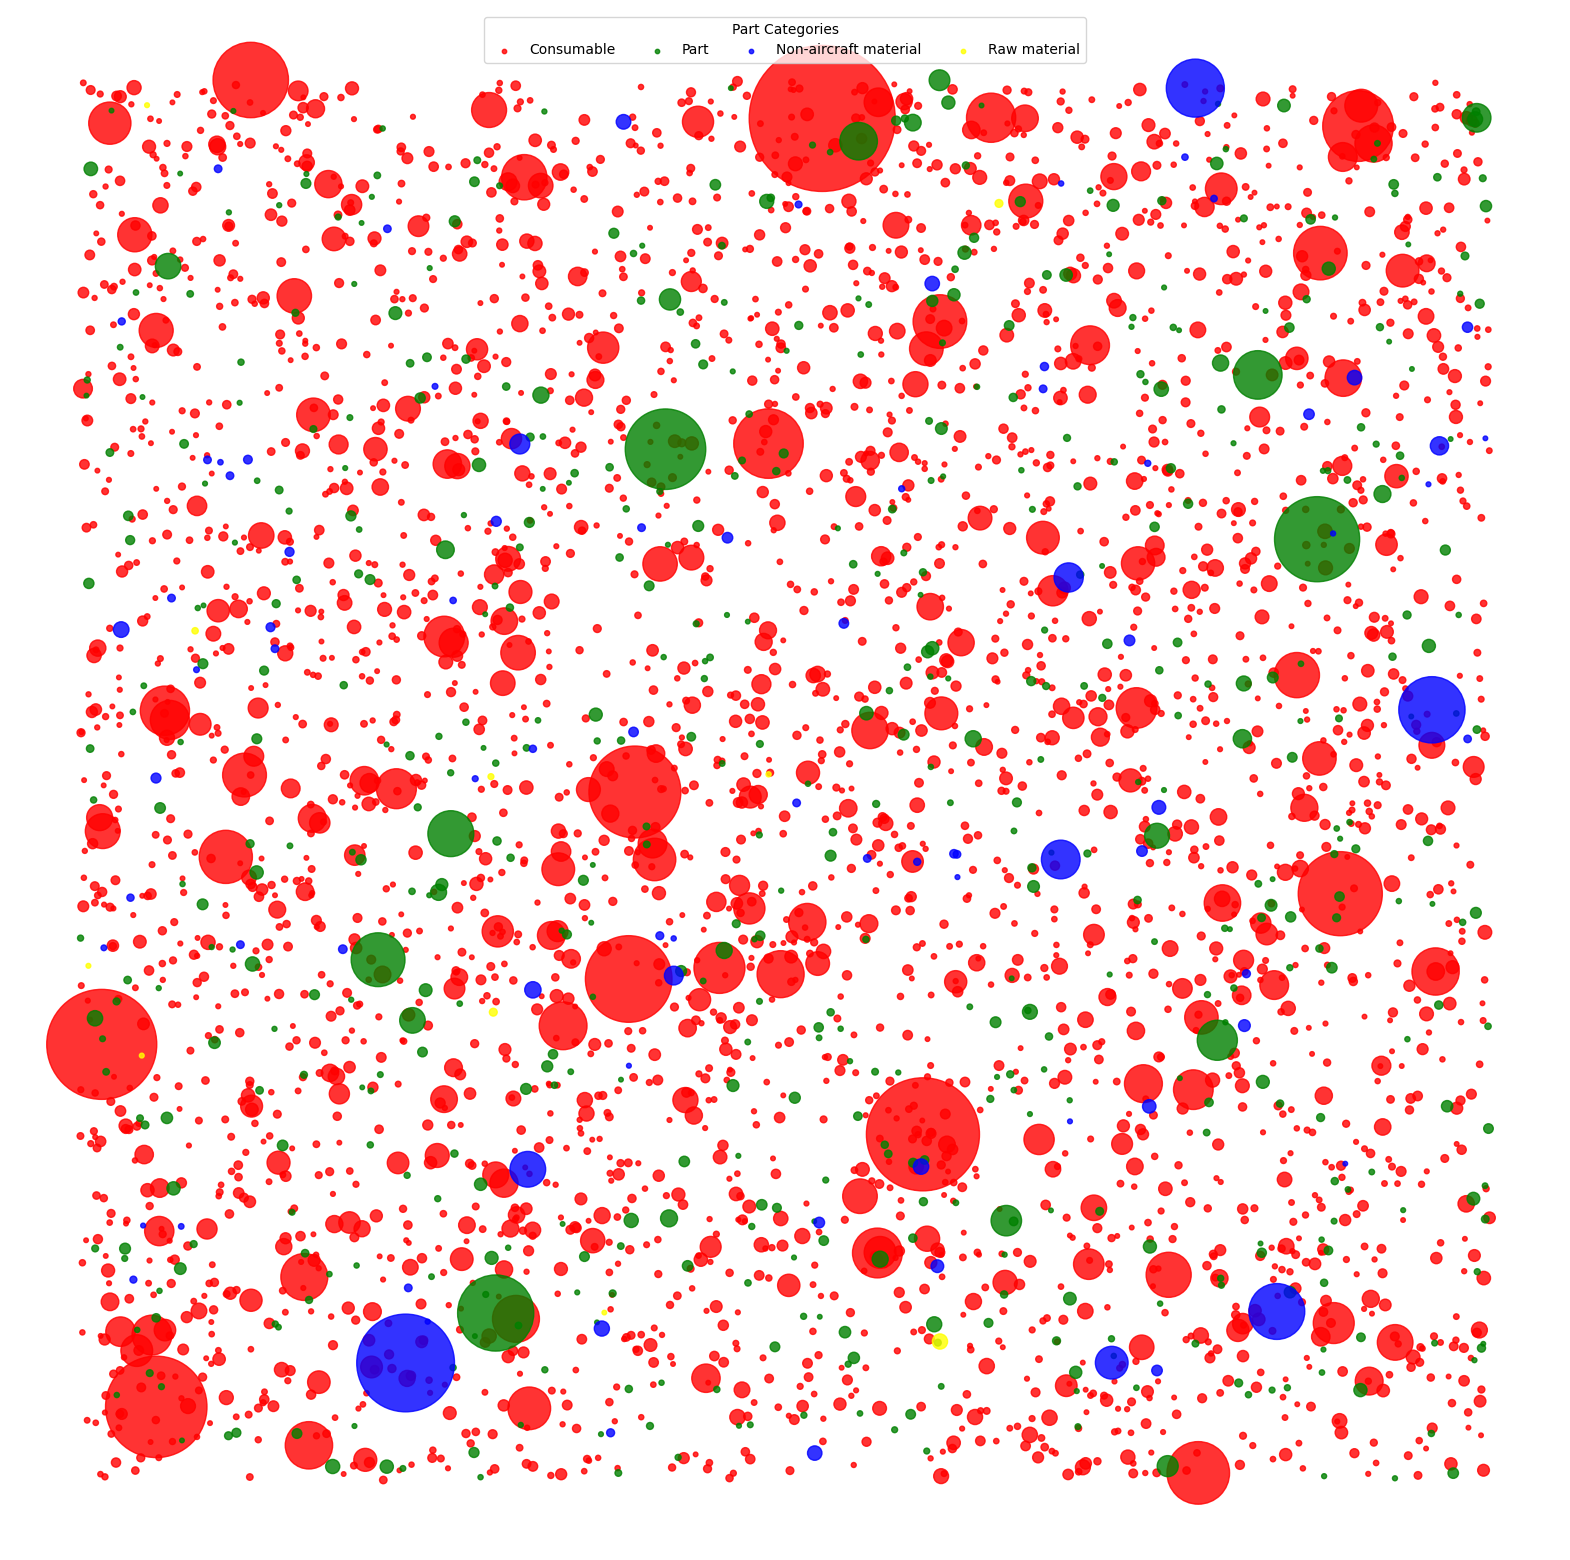

In [16]:
pos=nx.random_layout(G) # nodes are placed at random in 2-dimensional space

fig, ax = plt.subplots(figsize=(20,20))
for category, color in color_map.items():
    category_nodes = [node for node in G.nodes() if G.nodes[node]["category"] == category]
    size_nodes=[G.nodes[node]["frequency"] for node in category_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=color, node_size=size_nodes, label=category, alpha=0.8)

plt.axis("off")
legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
for handle in legend.legend_handles:
    handle.set_sizes([10])
plt.show()

## Create edges with weights from 'edges.csv'
Every row in the dataframe corresponds to a pickslip.  
The parts that appear in a pickslip (see 'part' column) are adjacent in the graph, i.e., an edge is formed for each distinct tuple of pickslip parts.  
The column 'edge_freq' corresponds to the number of appearances of a pickslip in the database.  
For example, the pickslip (see row $1$ of df_edges below) which consists of part_8589989186 and part_8589990685	appears $2$ times in the database.   
ATTENTION! These parts may appear (together along with other parts /separately) in other pickslips.

In [17]:
df_edges=pd.read_csv('edges.csv')
df_edges['parts']=df_edges['parts_m'].str.split(',')

In [18]:
df_edges=df_edges[['parts','edge_freq']]
df_edges

parts  edge_freq
0      [part_8589935459, part_8589935945, part_858993...          1
1                     [part_8589989186, part_8589990685]          2
2      [part_8589944781, part_8589944787, part_858994...          3
3                     [part_8589934897, part_8590209097]          1
4      [part_8589936087, part_8589949124, part_859000...          1
...                                                  ...        ...
25286  [part_8589953413, part_8589957887, part_858997...          2
25287  [part_8589979837, part_8589979838, part_858997...          2
25288                 [part_8589940804, part_8589940806]         10
25289                 [part_8590096130, part_8590275520]          1
25290                 [part_8589934974, part_8589935193]          9

[25291 rows x 2 columns]

### Compute edge weights
Parts $u$, $v$ are connected with an edge of weight $w$, if $u$ and $v$ co-appear in $w$ pickslips

In [19]:
for index, row in tqdm(df_edges.iterrows()):
    edgelist = row["parts"]
    edge_freq = row["edge_freq"]
    for i in range(len(edgelist)):
      for j in range(i+1,len(edgelist)): #no selfedges
        if (edgelist[i],edgelist[j]) in G.edges() and edgelist[i] in G.nodes() and edgelist[j] in G.nodes():
          G[edgelist[i]][edgelist[j]]['weight']+=edge_freq
        elif (edgelist[i],edgelist[j]) not in G.edges() and edgelist[i] in G.nodes() and edgelist[j] in G.nodes():
          G.add_edge(edgelist[i], edgelist[j], weight=edge_freq)

25291it [00:07, 3485.48it/s]


In [20]:
df_edges_new = nx.to_pandas_edgelist(G)

In [21]:
b=dict(G.edges())
print('Number of edges:',len(b))
df_edges_new.sort_values(by=['weight'],ascending=False)

Number of edges: 107900


source           target  weight
107028  part_8589934694  part_8589934678    5211
78610   part_8589935129  part_8589935130    3864
78608   part_8589935129  part_8589935118    3837
88172   part_8589935118  part_8589935130    3833
78607   part_8589935129  part_8589934989    2524
...                 ...              ...     ...
66338   part_8589934827  part_8589945294       1
66339   part_8589934827  part_8589945295       1
66340   part_8589934827  part_8589947166       1
66341   part_8589934827  part_8589947731       1
107899  part_8589935306  part_8589934678       1

[107900 rows x 3 columns]

### Weak edges: Edges with weight $\leq$ 1

In [22]:

df_edges_new[df_edges_new['weight']<=1].sort_values(by=['weight'],ascending=False)

source           target  weight
7       part_8589989186  part_8589976454       1
70824   part_8589941783  part_8589944259       1
70770   part_8589941783  part_8589937078       1
70772   part_8589941783  part_8589940749       1
70774   part_8589941783  part_8589944966       1
...                 ...              ...     ...
34709   part_8589942503  part_8589951851       1
34710   part_8589942503  part_8589953690       1
34711   part_8589942503  part_8589958093       1
34713   part_8589942503  part_8589958252       1
107899  part_8589935306  part_8589934678       1

[57966 rows x 3 columns]

In [23]:
G=nx.from_pandas_edgelist(df_edges_new, 'source', 'target', ['weight'], nx.Graph())

In [24]:
for node in G.nodes():
  node_strength=0
  pickslip_no=[]
  for neighbor in G.neighbors(node):
    temp = G[node][neighbor]['weight']
    pickslip_no.append(temp)
    node_strength += temp
  G.nodes[node]['strength']=node_strength
  G.nodes[node]['pickslips']=max(pickslip_no)

In [25]:
for n in tqdm(G.nodes()):
  G.nodes[n]['frequency']=df_nodes_new[df_nodes_new['part_id']==n]['part_abs_freq'].tolist()[0]
  G.nodes[n]['category']=df_nodes_new[df_nodes_new['part_id']==n]['type'].tolist()[0]

100%|██████████| 3771/3771 [00:15<00:00, 236.28it/s]


In [26]:
frequency_counts = df_edges_new['weight'].value_counts()
c=dict(frequency_counts)
c={key: c[key] for key in sorted(c)}
# key: number of coappearences
# value: number of edges with the corresponding key value (two parts coappear in $key$ pickslips)
print(c)

{1: 57966, 2: 15816, 3: 7108, 4: 3653, 5: 2287, 6: 1646, 7: 1217, 8: 1223, 9: 1059, 10: 1379, 11: 1527, 12: 936, 13: 543, 14: 489, 15: 639, 16: 540, 17: 532, 18: 766, 19: 785, 20: 699, 21: 408, 22: 279, 23: 319, 24: 372, 25: 253, 26: 207, 27: 158, 28: 115, 29: 147, 30: 182, 31: 111, 32: 128, 33: 148, 34: 144, 35: 140, 36: 174, 37: 168, 38: 104, 39: 114, 40: 115, 41: 132, 42: 111, 43: 109, 44: 149, 45: 100, 46: 79, 47: 78, 48: 29, 49: 32, 50: 56, 51: 42, 52: 51, 53: 39, 54: 55, 55: 36, 56: 46, 57: 41, 58: 31, 59: 48, 60: 49, 61: 28, 62: 52, 63: 38, 64: 43, 65: 34, 66: 37, 67: 28, 68: 39, 69: 64, 70: 35, 71: 50, 72: 51, 73: 33, 74: 67, 75: 37, 76: 36, 77: 29, 78: 30, 79: 33, 80: 54, 81: 49, 82: 45, 83: 43, 84: 27, 85: 36, 86: 32, 87: 21, 88: 32, 89: 76, 90: 149, 91: 131, 92: 31, 93: 20, 94: 14, 95: 14, 96: 9, 97: 10, 98: 11, 99: 26, 100: 24, 101: 15, 102: 11, 103: 16, 104: 6, 105: 8, 106: 6, 107: 6, 108: 10, 109: 4, 110: 4, 111: 6, 112: 2, 113: 9, 114: 5, 115: 4, 116: 5, 117: 5, 118: 2, 

### Prune the network using an edge-frequency threshold: Parts that coappear in less than 'edge-thres' pickslips, are dropped.

In [27]:
# drop the edges with weight<=edge_thres

edges_to_remove = []
for edge in tqdm(G.edges(data=True)):
  if edge[2].get("weight") <= edge_thres:
      edges_to_remove.append((edge[0], edge[1]))

G.remove_edges_from(edges_to_remove)

100%|██████████| 107900/107900 [00:00<00:00, 329099.94it/s]


In [28]:
print('Current graph elements')
print('----------------------')
c=dict(G.nodes())
print('Number of nodes:',len(c))
b=dict(G.edges())
print('Number of edges:',len(b))

Current graph elements
----------------------
Number of nodes: 3771
Number of edges: 27010


### After deleting edges, some nodes become singletons. These will also be dropped.

In [29]:
# drop nodes with 0 degree
nodes_to_remove = []
deg=dict(G.degree())
for node in tqdm(G.nodes()):
  if deg[node]==0:
      nodes_to_remove.append(node)

print('')
print('')
print(len(nodes_to_remove),' nodes will be dropped due weak ties.')
node_name=[]
node_frequency=[]
node_type=[]
node_strength=[]
node_pickslips=[]
for n in nodes_to_remove:
  node_name.append(n)
  node_frequency.append(G.nodes[n]['frequency'])
  node_type.append(G.nodes[n]['category'])
  node_strength.append(G.nodes[n]['strength'])
  node_pickslips.append(G.nodes[n]['pickslips'])
data=dict()
data={'part':node_name,'frequency':node_frequency,'type':node_type,'strength':node_strength,'max_edge_strength':node_pickslips}
df_remove=pd.DataFrame.from_dict(data)

G.remove_nodes_from(nodes_to_remove)
df_remove.sort_values(by=['strength'],ascending=False)

100%|██████████| 3771/3771 [00:00<00:00, 1035261.18it/s]



688  nodes will be dropped due weak ties.


part  frequency        type  strength  max_edge_strength
47   part_8589965611         32  Consumable       230                  3
34   part_8589943849         13  Consumable       207                  3
5    part_8589961719         11  Consumable       180                  2
81   part_8589950249         12  Consumable       180                  3
123  part_8589989019         12        Part       177                  2
..               ...        ...         ...       ...                ...
638  part_8589945364         16        Part         1                  1
643  part_8589955836         27        Part         1                  1
645  part_8590150981         11  Consumable         1                  1
646  part_8589962822         27  Consumable         1                  1
687  part_8589935749         12  Consumable         1                  1

[688 rows x 5 columns]

# Resulting graph info & properties

In [30]:
print('Final graph elements')
print('----------------------')
c=dict(G.nodes())
print('Number of nodes:',len(c))
b=dict(G.edges())
print('Number of edges:',len(b))

Final graph elements
----------------------
Number of nodes: 3083
Number of edges: 27010


## Degree distribution

In [31]:
def degree_hist(G):
  G_degree=G.degree()
  a=[]
  for i,j in G_degree:
      a.append(j)
  plt.hist(a, bins=50, edgecolor='black')
  plt.title("Degree distribution")
  plt.ylabel("Count")
  plt.xlabel("Degree")
  plt.show()
  print("Average Degree:", np.mean(a))
  print("Standard Deviation:", np.std(a))
  print("Minimun Degree:", min(a))
  print("Maximum Degree:", max(a))

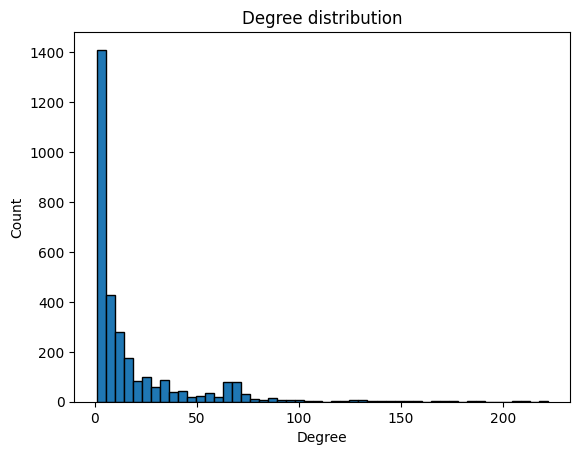

Average Degree: 17.521894258838792
Standard Deviation: 26.242162212106358
Minimun Degree: 1
Maximum Degree: 222


In [32]:
degree_hist(G)

## Node Strength distribution
 $Strength(u)$ : # of u co-appearences

In [33]:
def strength_hist(G):
  strength=[]
  for node in G.nodes():
    node_strength=0
    for neighbor in G.neighbors(node):
      temp = G[node][neighbor]['weight']
      node_strength += temp
    strength.append(node_strength)

  plt.hist(strength, bins=50, edgecolor='black')
  plt.title("Node Strength distribution")
  plt.ylabel("Count")
  plt.xlabel("Strength")
  plt.show()
  print('')
  print("Average Strength:", np.mean(strength))
  print("Standard Deviation:", np.std(strength))
  print("Minimun Strength:", min(strength))
  print("Maximum Strength:", max(strength))

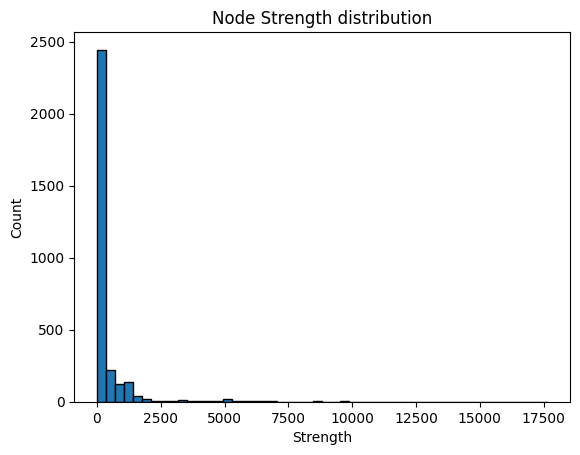


Average Strength: 396.6850470321116
Standard Deviation: 1121.9461956944733
Minimun Strength: 4
Maximum Strength: 17664


In [34]:
strength_hist(G)

## Visualize resulting network

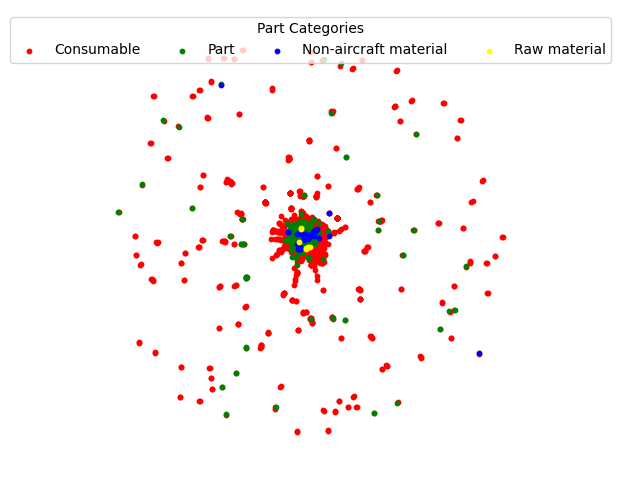

In [35]:
fig, ax = plt.subplots(figsize=(6,6))

pos=nx.spring_layout(G)

for category, color in color_map.items():
    category_nodes = [node for node in G.nodes() if G.nodes[node]["category"] == category]
    size_nodes=[G.nodes[node]["frequency"] for node in category_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=color, label=category,node_size=10)

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.9)

plt.axis("off")
legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
for handle in legend.legend_handles:
    handle.set_sizes([10])
plt.show()

# Premier partition: Connected components analysis

## Size of connected components

Connected components analysis
-----------------------------
Number_of_connected_components: 149
Connected components size: [2618, 17, 12, 10, 10, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]



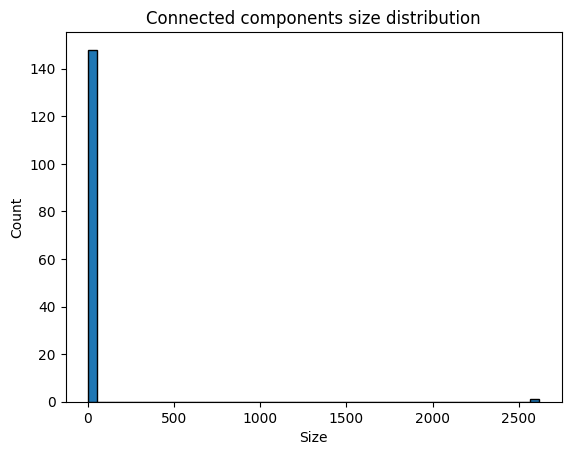


Average Size: 20.691275167785236
Size Median: 2.0
Size Standard Deviation: 213.5088417240539
Minimun Size: 2
Maximum Size: 2618


In [36]:
print('Connected components analysis')
print('-----------------------------')
connected_components_size=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
number_of_connected_components=len(connected_components_size)
S = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Number_of_connected_components:',number_of_connected_components)
print('Connected components size:', connected_components_size)
print('')

plt.hist(connected_components_size, bins=50, edgecolor='black')
plt.title("Connected components size distribution")
plt.ylabel("Count")
plt.xlabel("Size")
plt.show()
print('')
print("Average Size:", np.mean(connected_components_size))
print("Size Median:", np.median(connected_components_size))
print("Size Standard Deviation:", np.std(connected_components_size))
print("Minimun Size:", min(connected_components_size))
print("Maximum Size:", max(connected_components_size))

In [37]:
# aggregate info
network_info=dict()
cc=[]
dens=[]
for i in range(len(S)):
  network_info[i]=dict()
  network_info[i]['cc']=nx.average_clustering(S[i])
  cc.append(nx.average_clustering(S[i]))
  network_info[i]['size']=connected_components_size[i]
  network_info[i]['density']=2*len(dict(S[i].edges()))/(len(dict(S[i].nodes()))*(len(dict(S[i].nodes()))-1))
  dens.append(2*len(dict(S[i].edges()))/(len(dict(S[i].nodes()))*(len(dict(S[i].nodes()))-1)))


## Average Clustering Coefficient

Component Average Clustering Coefficient



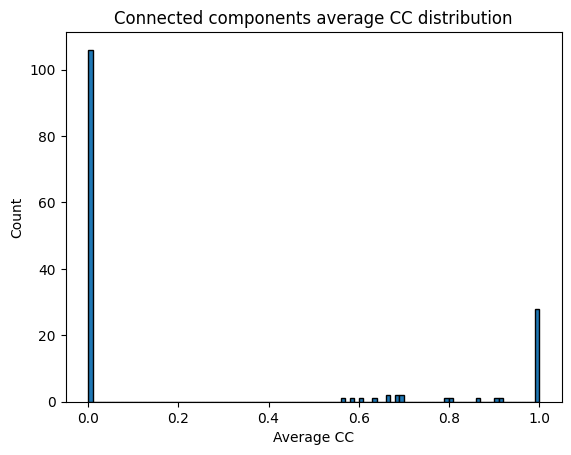


Component Average CC: 0.26017263522573264
Component CC Standard Deviation: 0.41627890954609975
Component Minimun CC: 0.0
Component Maximum CC: 1.0


In [38]:
print('Component Average Clustering Coefficient')
print('')
plt.hist(cc, bins=100, edgecolor='black')
plt.title("Connected components average CC distribution")
plt.ylabel("Count")
plt.xlabel("Average CC")
plt.show()
print('')
print("Component Average CC:", np.mean(cc))
print("Component CC Standard Deviation:", np.std(cc))
print("Component Minimun CC:", min(cc))
print("Component Maximum CC:", max(cc))


## Average Density

Component Average Density



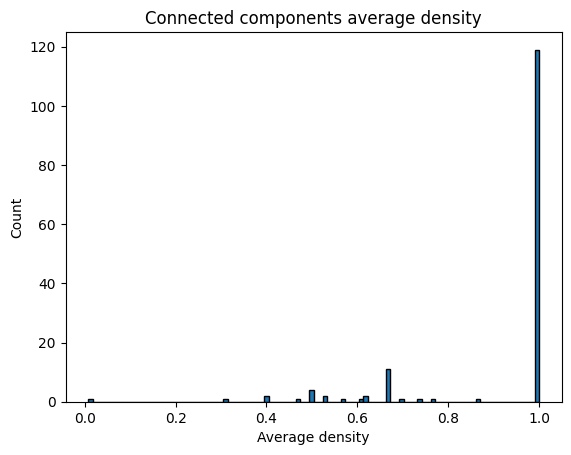


Component Average density: 0.9159032690794331
Component density Standard Deviation: 0.18181893279305283
Component Minimun density: 0.007682330930774366
Component Maximum density: 1.0


In [39]:
print('Component Average Density')
print('')
plt.hist(dens, bins=100, edgecolor='black')
plt.title("Connected components average density")
plt.ylabel("Count")
plt.xlabel("Average density")
plt.show()
print('')
print("Component Average density:", np.mean(dens))
print("Component density Standard Deviation:", np.std(dens))
print("Component Minimun density:", min(dens))
print("Component Maximum density:", max(dens))

## Visualize connected components

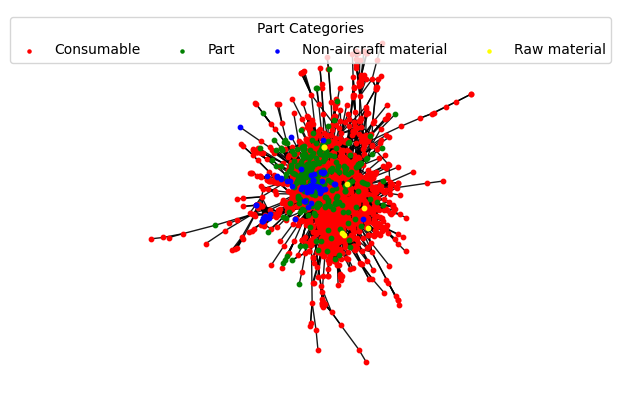

Component 0 : Graph with 2618 nodes and 26317 edges
Size: 2618
Average clustering coefficient:  0.6608284687399877
Density: 0.007682330930774366



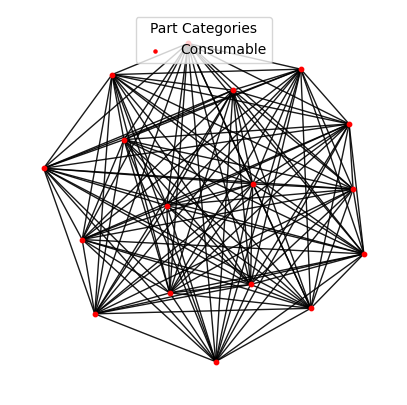

Component 1 : Graph with 17 nodes and 136 edges
Size: 17
Average clustering coefficient:  1.0
Density: 1.0



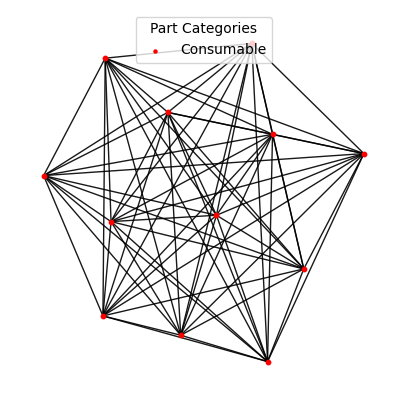

Component 2 : Graph with 12 nodes and 66 edges
Size: 12
Average clustering coefficient:  1.0
Density: 1.0



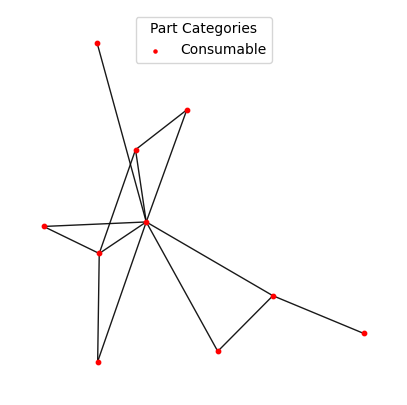

Component 3 : Graph with 10 nodes and 14 edges
Size: 10
Average clustering coefficient:  0.567857142857143
Density: 0.3111111111111111



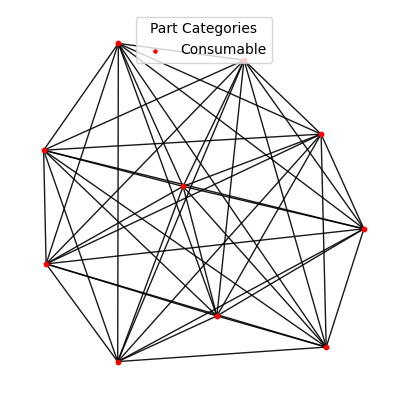

Component 4 : Graph with 10 nodes and 45 edges
Size: 10
Average clustering coefficient:  1.0
Density: 1.0



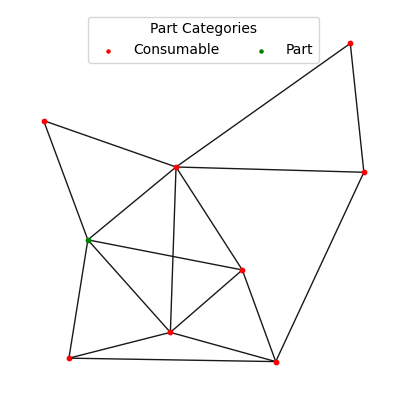

Component 5 : Graph with 9 nodes and 17 edges
Size: 9
Average clustering coefficient:  0.6037037037037037
Density: 0.4722222222222222



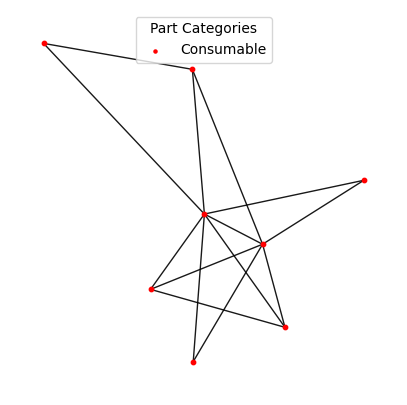

Component 6 : Graph with 8 nodes and 14 edges
Size: 8
Average clustering coefficient:  0.7999999999999999
Density: 0.5



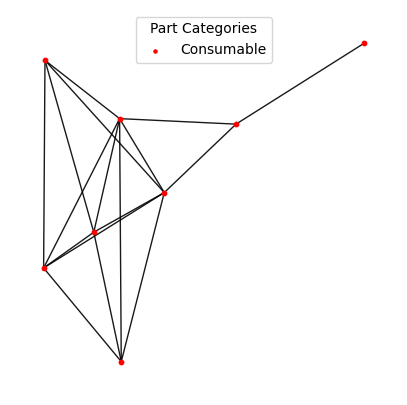

Component 7 : Graph with 8 nodes and 17 edges
Size: 8
Average clustering coefficient:  0.6833333333333333
Density: 0.6071428571428571



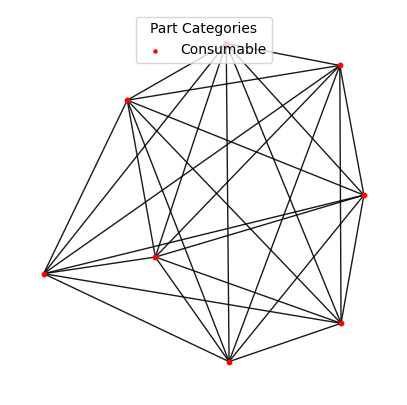

Component 8 : Graph with 8 nodes and 28 edges
Size: 8
Average clustering coefficient:  1.0
Density: 1.0



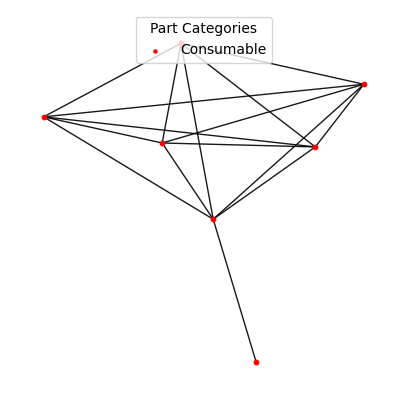

Component 9 : Graph with 7 nodes and 16 edges
Size: 7
Average clustering coefficient:  0.8095238095238094
Density: 0.7619047619047619



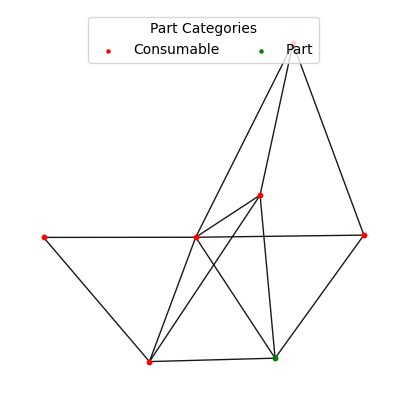

Component 10 : Graph with 7 nodes and 13 edges
Size: 7
Average clustering coefficient:  0.6857142857142857
Density: 0.6190476190476191



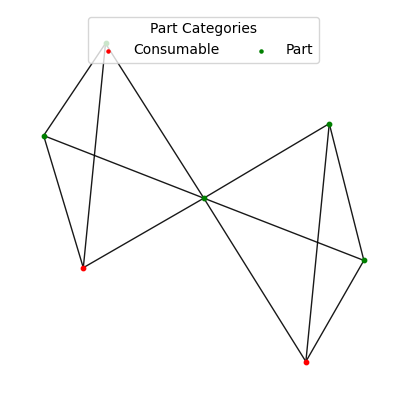

Component 11 : Graph with 7 nodes and 12 edges
Size: 7
Average clustering coefficient:  0.9142857142857144
Density: 0.5714285714285714



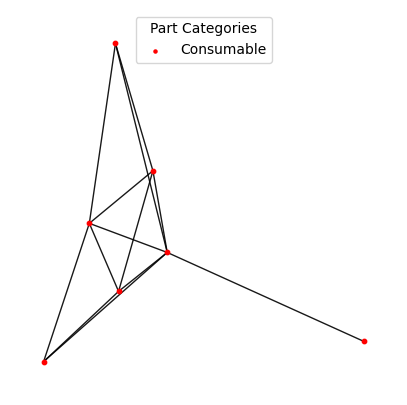

Component 12 : Graph with 7 nodes and 13 edges
Size: 7
Average clustering coefficient:  0.6904761904761905
Density: 0.6190476190476191



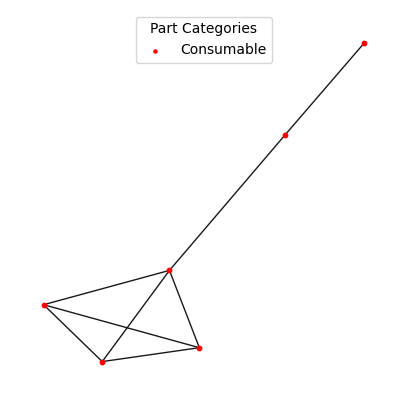

Component 13 : Graph with 6 nodes and 8 edges
Size: 6
Average clustering coefficient:  0.5833333333333334
Density: 0.5333333333333333



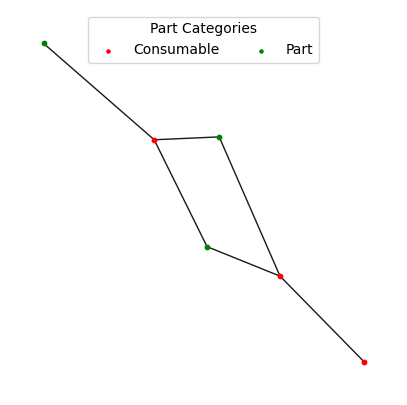

Component 14 : Graph with 6 nodes and 6 edges
Size: 6
Average clustering coefficient:  0.0
Density: 0.4



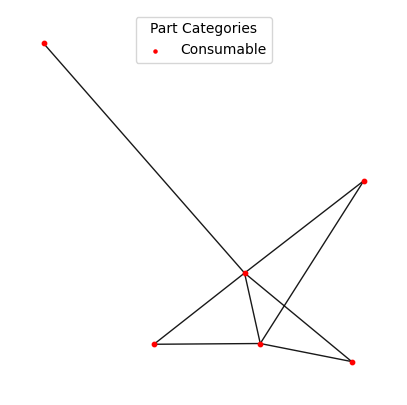

Component 15 : Graph with 6 nodes and 8 edges
Size: 6
Average clustering coefficient:  0.6333333333333333
Density: 0.5333333333333333



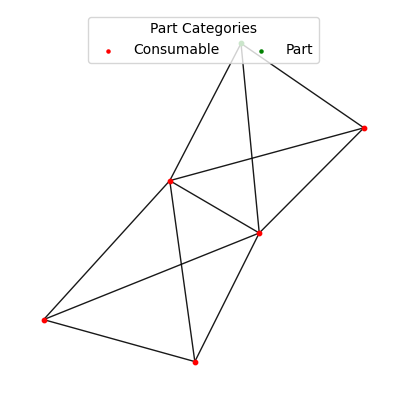

Component 16 : Graph with 6 nodes and 11 edges
Size: 6
Average clustering coefficient:  0.8666666666666666
Density: 0.7333333333333333



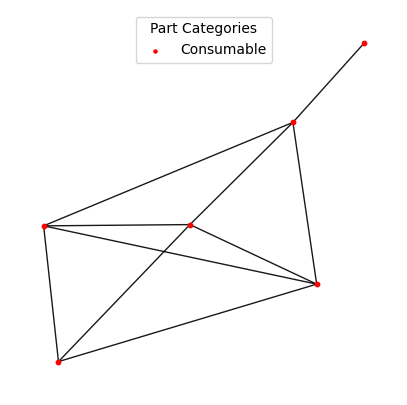

Component 17 : Graph with 6 nodes and 10 edges
Size: 6
Average clustering coefficient:  0.6666666666666666
Density: 0.6666666666666666



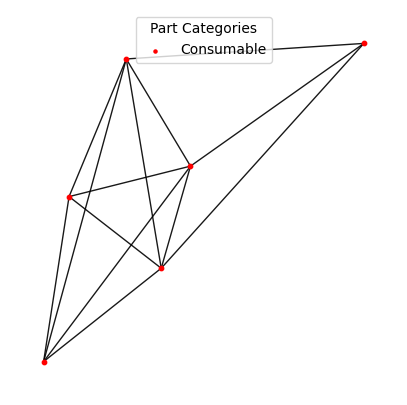

Component 18 : Graph with 6 nodes and 13 edges
Size: 6
Average clustering coefficient:  0.9
Density: 0.8666666666666667



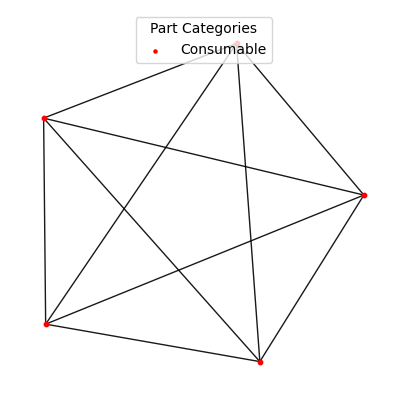

Component 19 : Graph with 5 nodes and 10 edges
Size: 5
Average clustering coefficient:  1.0
Density: 1.0



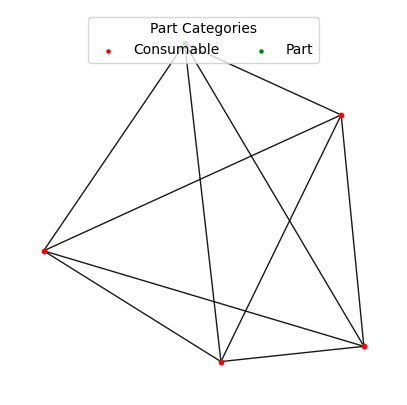

Component 20 : Graph with 5 nodes and 10 edges
Size: 5
Average clustering coefficient:  1.0
Density: 1.0



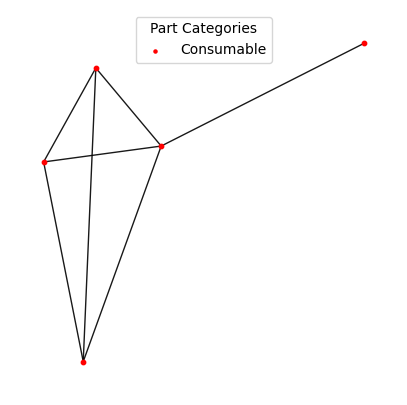

Component 21 : Graph with 5 nodes and 7 edges
Size: 5
Average clustering coefficient:  0.7
Density: 0.7



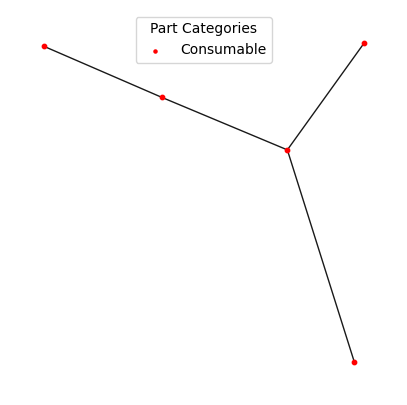

Component 22 : Graph with 5 nodes and 4 edges
Size: 5
Average clustering coefficient:  0.0
Density: 0.4



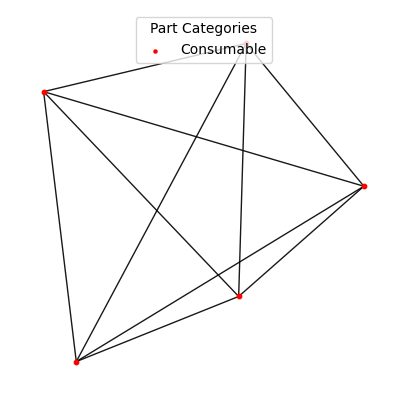

Component 23 : Graph with 5 nodes and 10 edges
Size: 5
Average clustering coefficient:  1.0
Density: 1.0



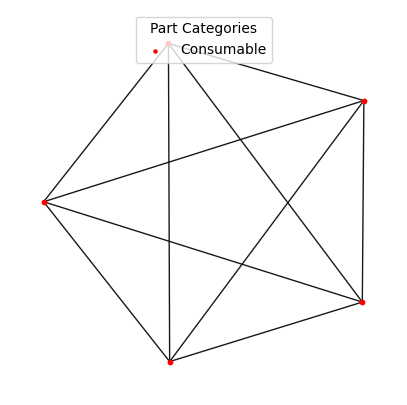

Component 24 : Graph with 5 nodes and 10 edges
Size: 5
Average clustering coefficient:  1.0
Density: 1.0



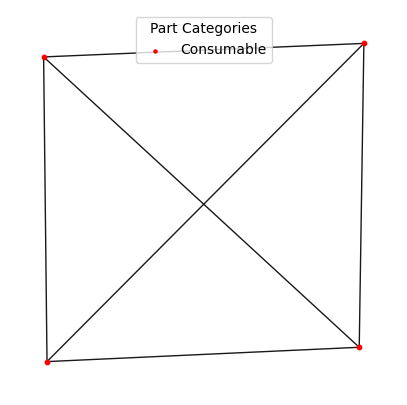

Component 25 : Graph with 4 nodes and 6 edges
Size: 4
Average clustering coefficient:  1.0
Density: 1.0



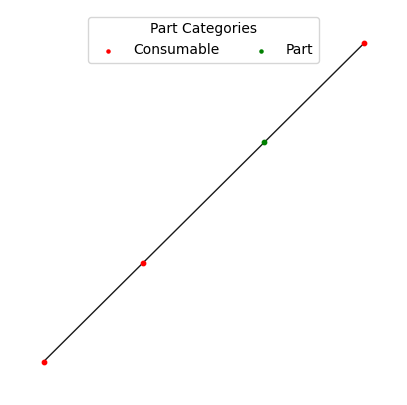

Component 26 : Graph with 4 nodes and 3 edges
Size: 4
Average clustering coefficient:  0.0
Density: 0.5



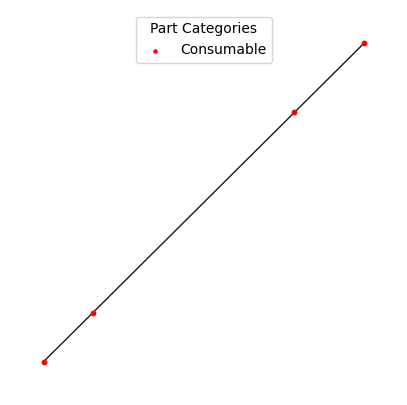

Component 27 : Graph with 4 nodes and 3 edges
Size: 4
Average clustering coefficient:  0.0
Density: 0.5



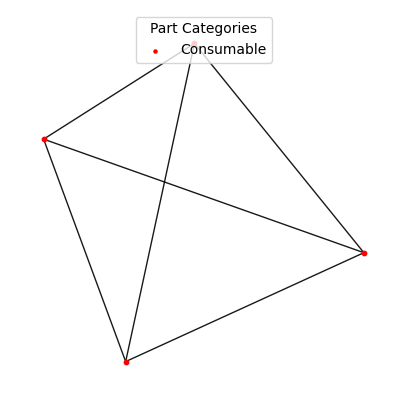

Component 28 : Graph with 4 nodes and 6 edges
Size: 4
Average clustering coefficient:  1.0
Density: 1.0



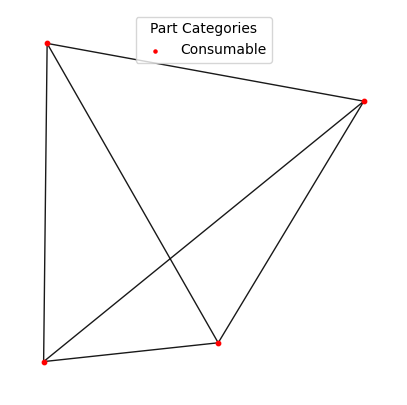

Component 29 : Graph with 4 nodes and 6 edges
Size: 4
Average clustering coefficient:  1.0
Density: 1.0



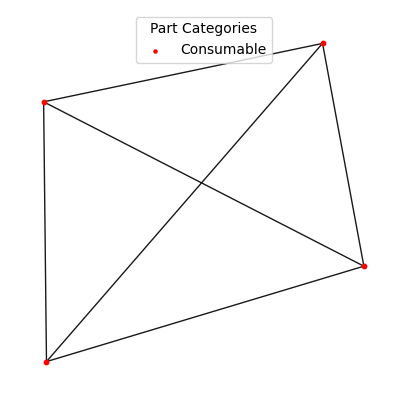

Component 30 : Graph with 4 nodes and 6 edges
Size: 4
Average clustering coefficient:  1.0
Density: 1.0



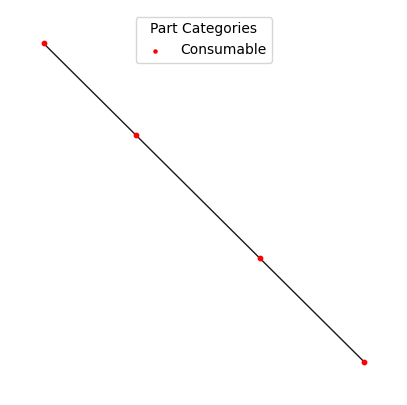

Component 31 : Graph with 4 nodes and 3 edges
Size: 4
Average clustering coefficient:  0.0
Density: 0.5



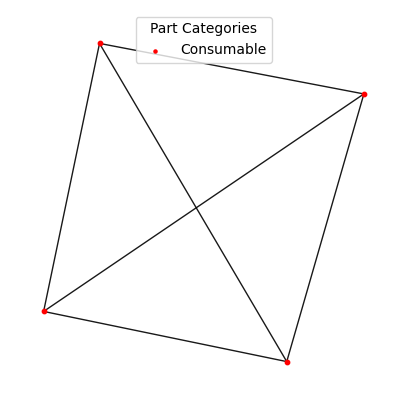

Component 32 : Graph with 4 nodes and 6 edges
Size: 4
Average clustering coefficient:  1.0
Density: 1.0



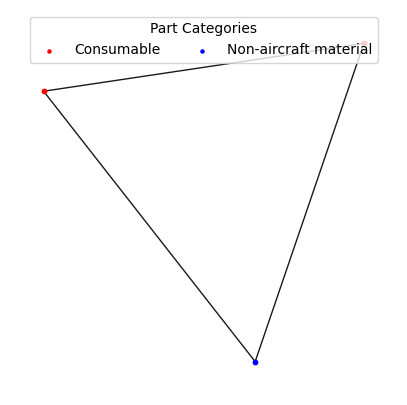

Component 33 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



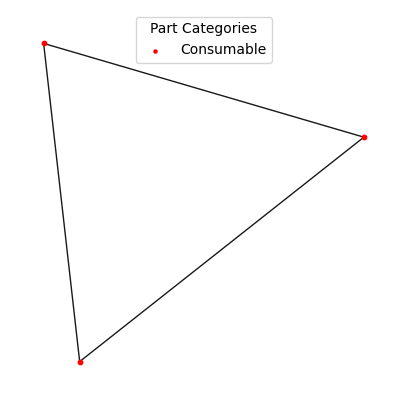

Component 34 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



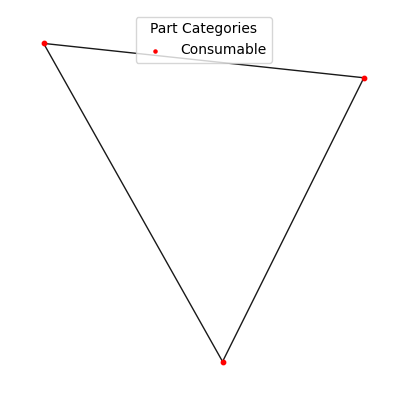

Component 35 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



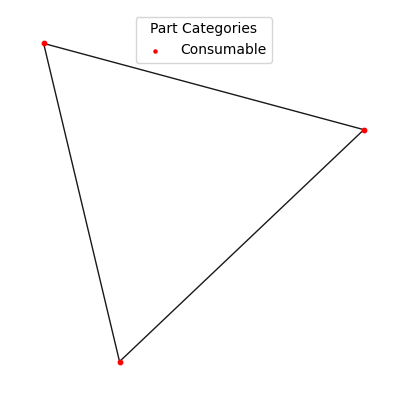

Component 36 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



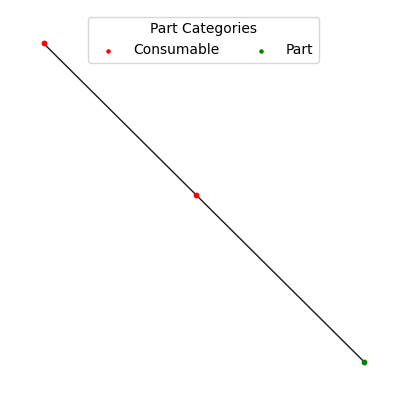

Component 37 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



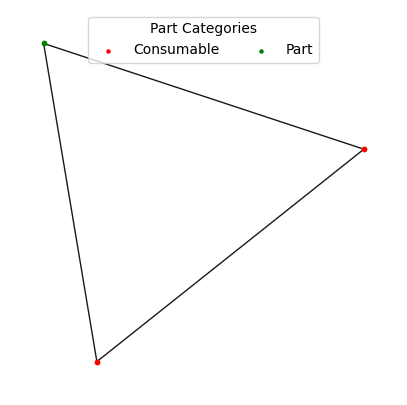

Component 38 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



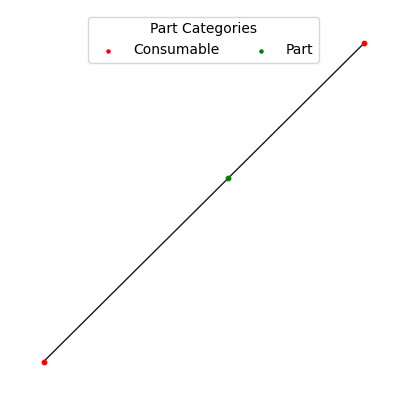

Component 39 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



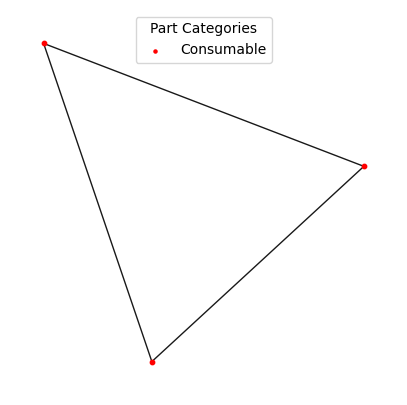

Component 40 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



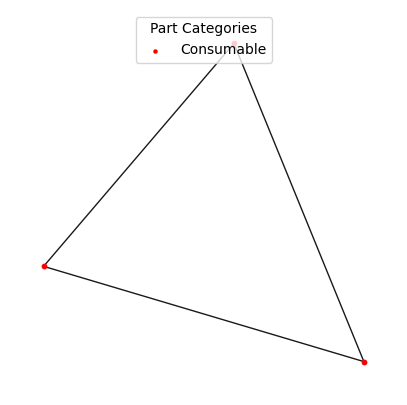

Component 41 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



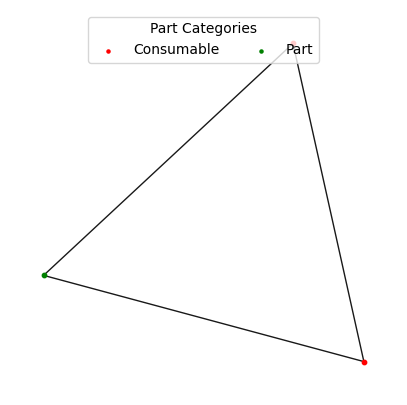

Component 42 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



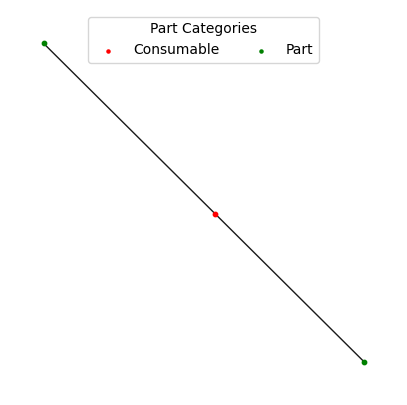

Component 43 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



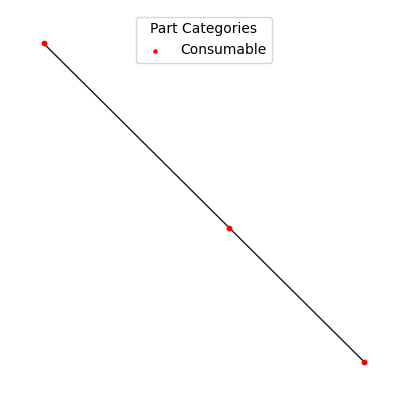

Component 44 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



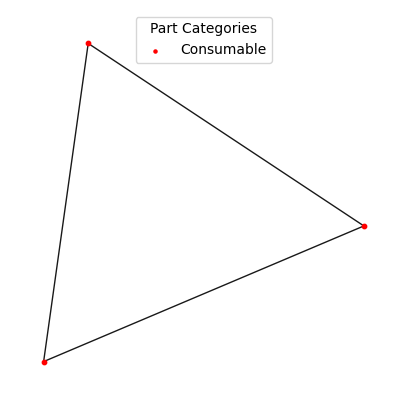

Component 45 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



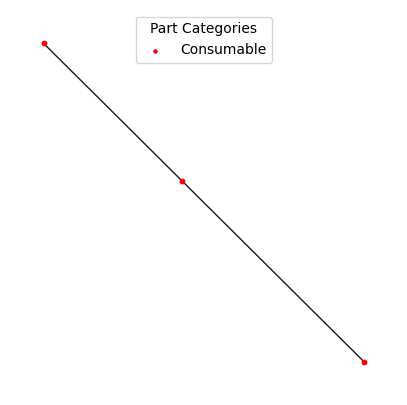

Component 46 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



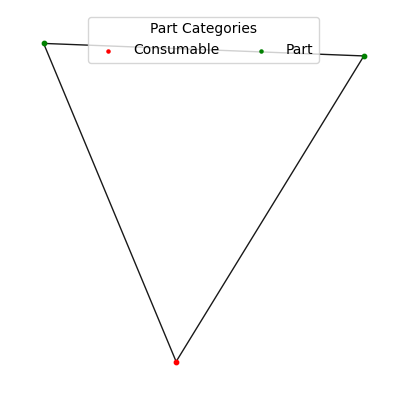

Component 47 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



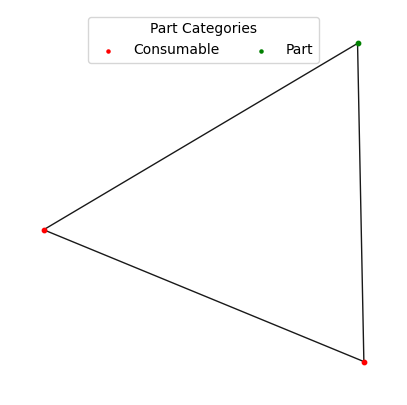

Component 48 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



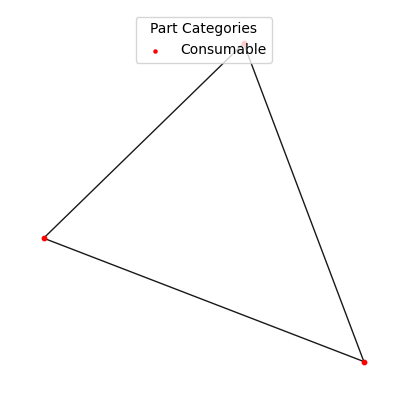

Component 49 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



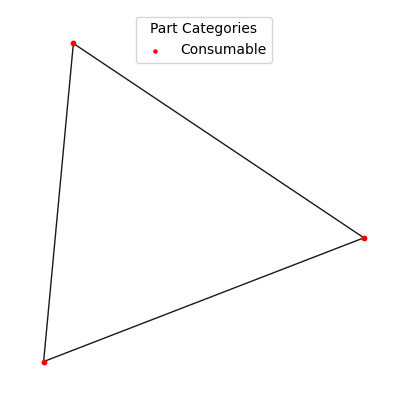

Component 50 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



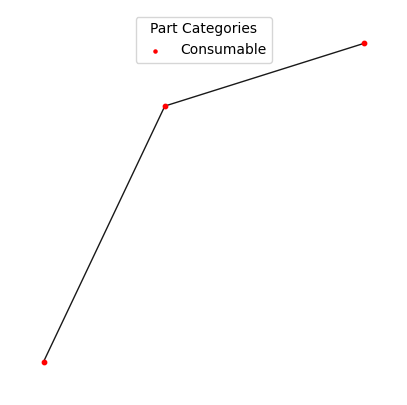

Component 51 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



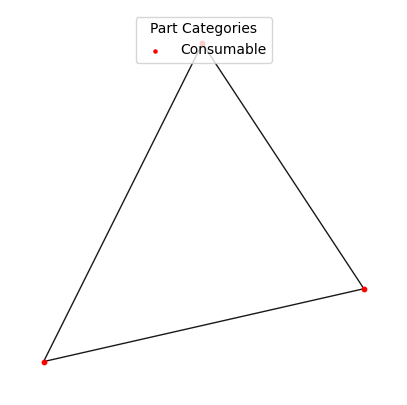

Component 52 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



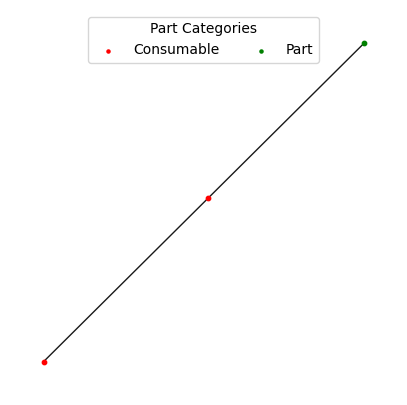

Component 53 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



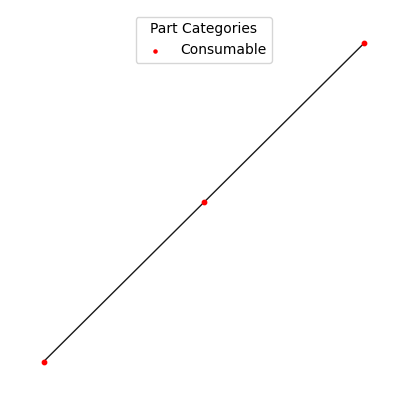

Component 54 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



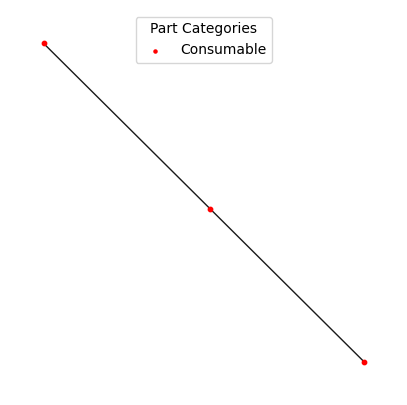

Component 55 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



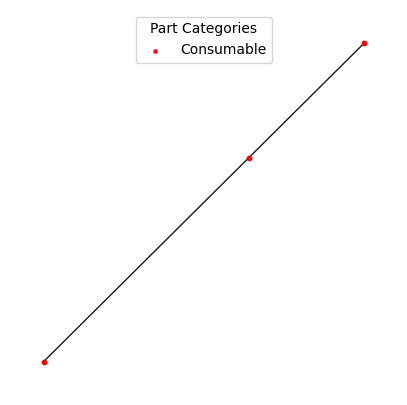

Component 56 : Graph with 3 nodes and 2 edges
Size: 3
Average clustering coefficient:  0.0
Density: 0.6666666666666666



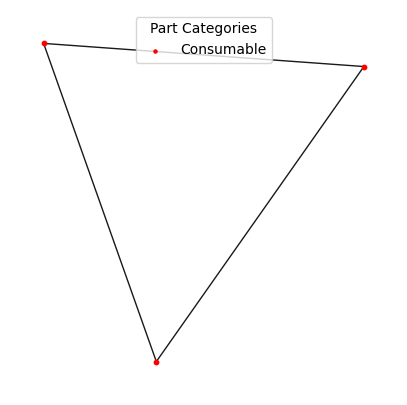

Component 57 : Graph with 3 nodes and 3 edges
Size: 3
Average clustering coefficient:  1.0
Density: 1.0



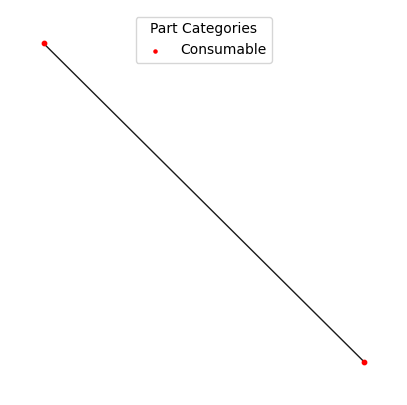

Component 58 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



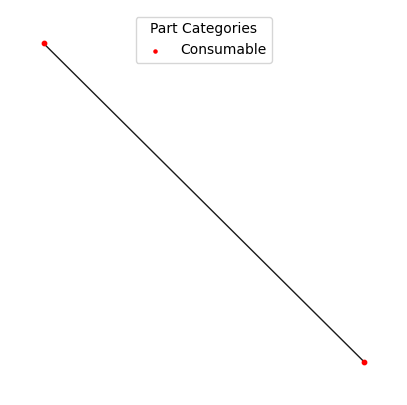

Component 59 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



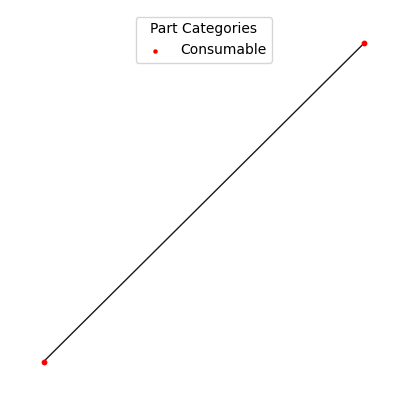

Component 60 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



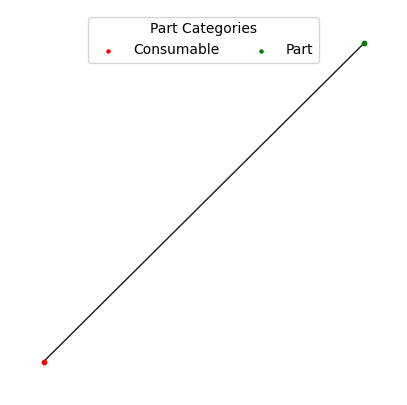

Component 61 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



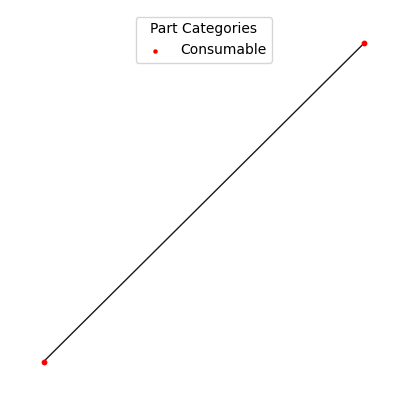

Component 62 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



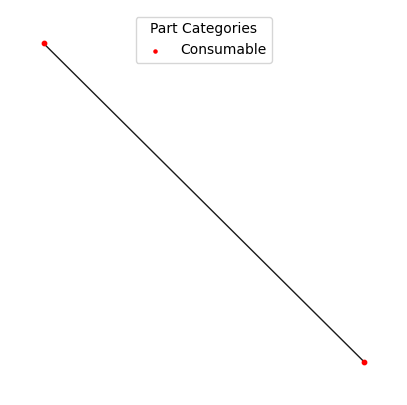

Component 63 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



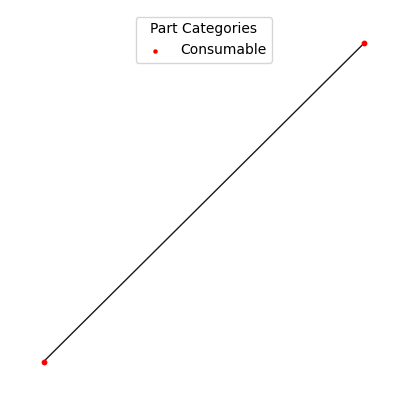

Component 64 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



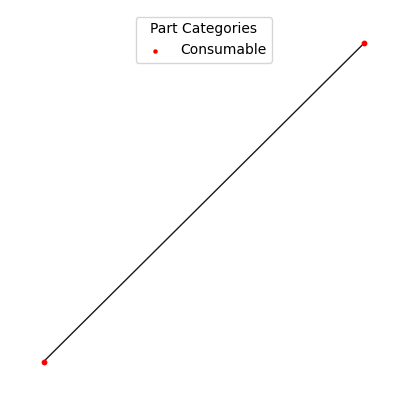

Component 65 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



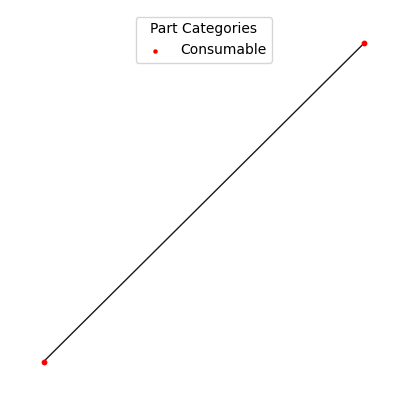

Component 66 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



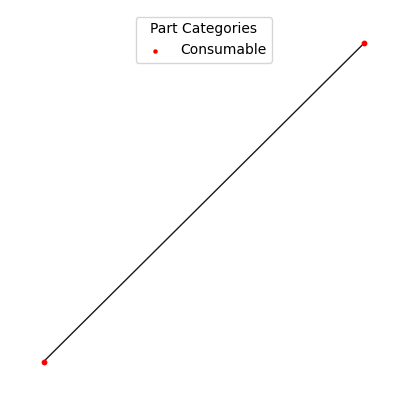

Component 67 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



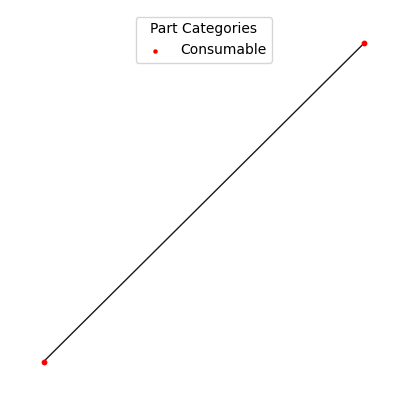

Component 68 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



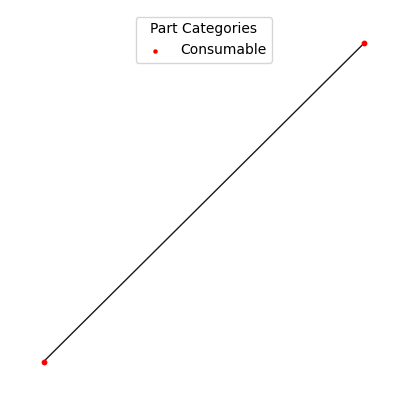

Component 69 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



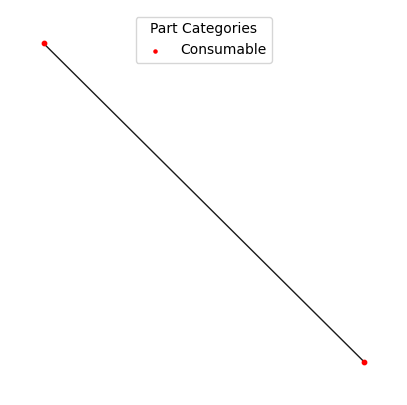

Component 70 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



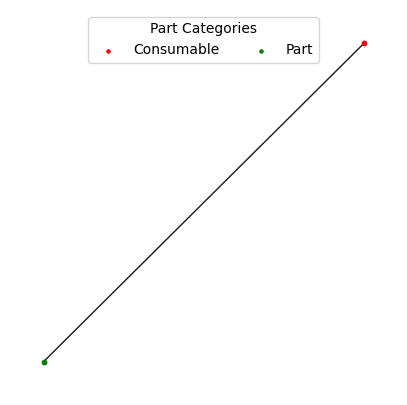

Component 71 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



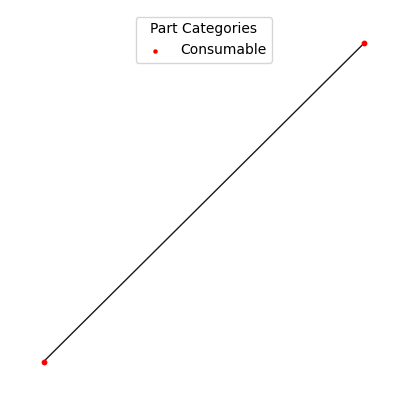

Component 72 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



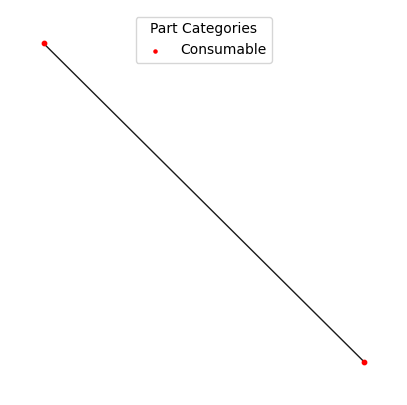

Component 73 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



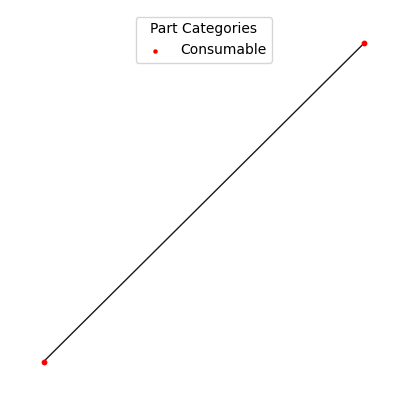

Component 74 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



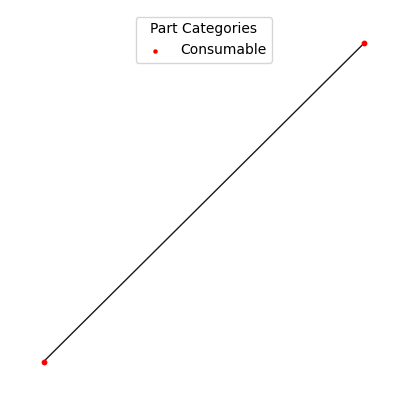

Component 75 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



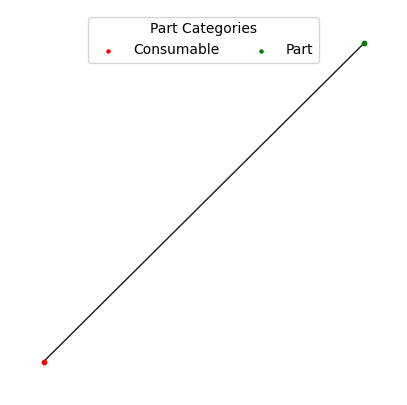

Component 76 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



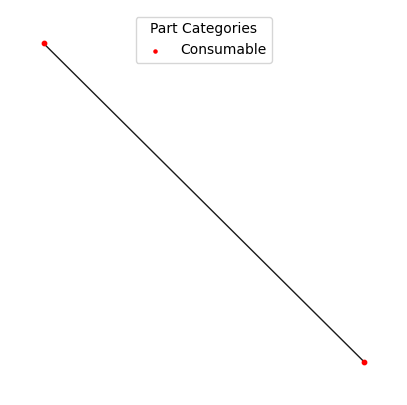

Component 77 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



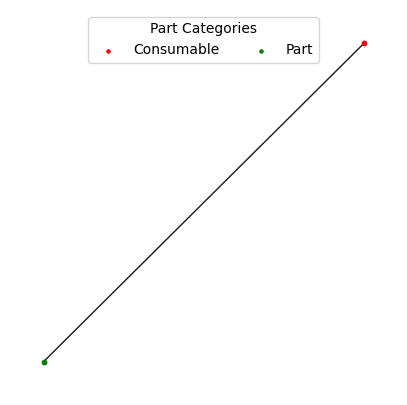

Component 78 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



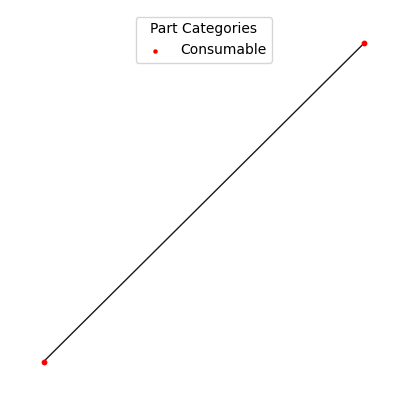

Component 79 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



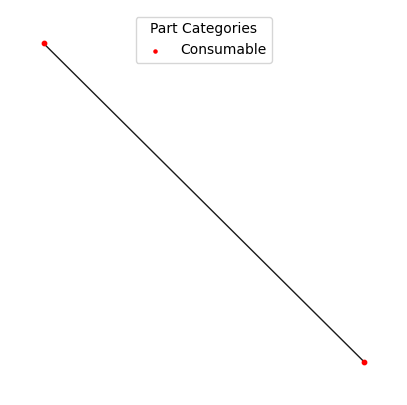

Component 80 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



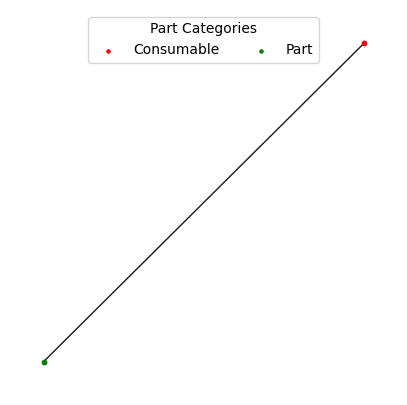

Component 81 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



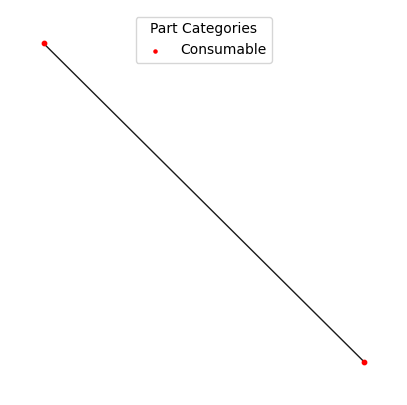

Component 82 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



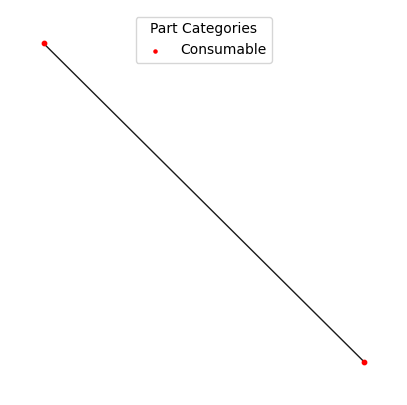

Component 83 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



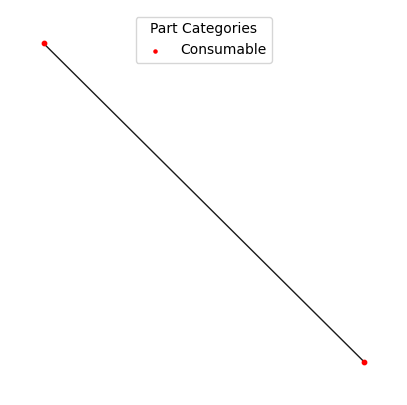

Component 84 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



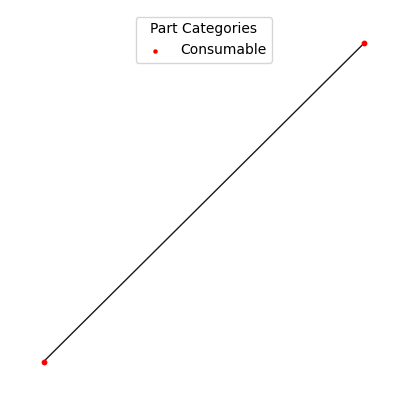

Component 85 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



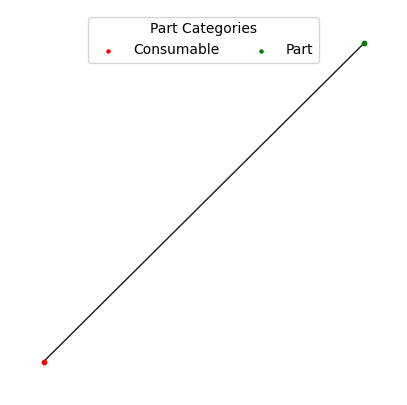

Component 86 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



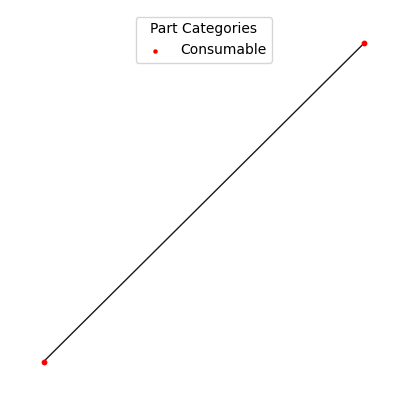

Component 87 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



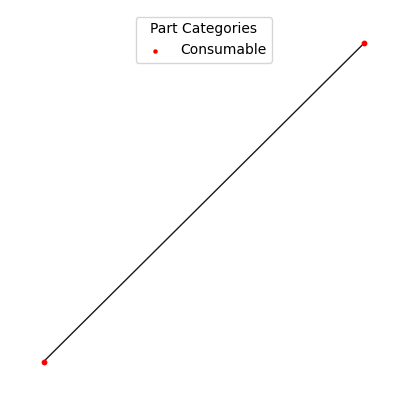

Component 88 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



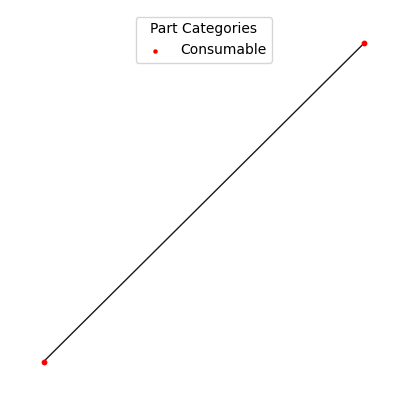

Component 89 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



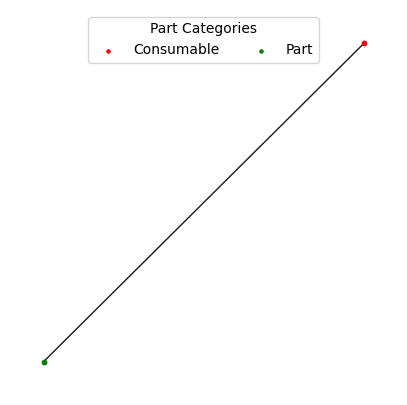

Component 90 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



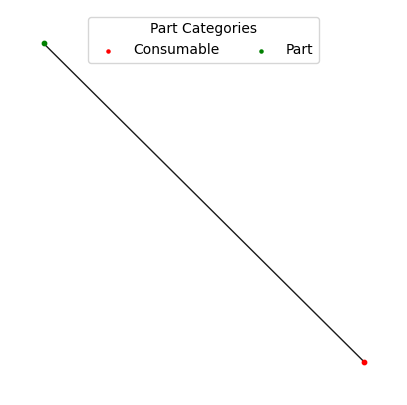

Component 91 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



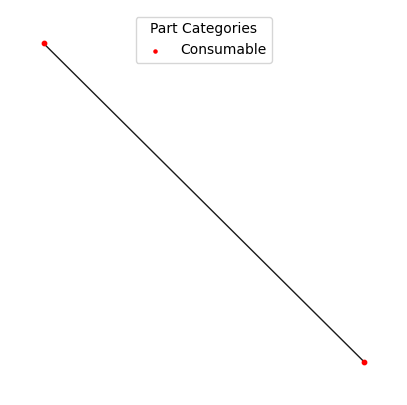

Component 92 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



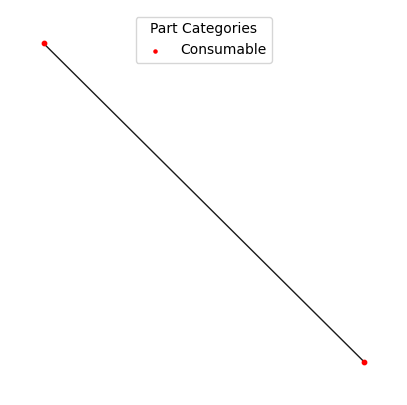

Component 93 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



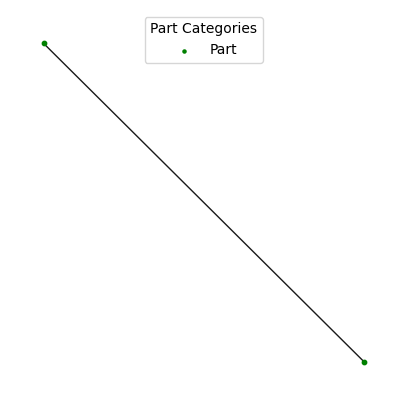

Component 94 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



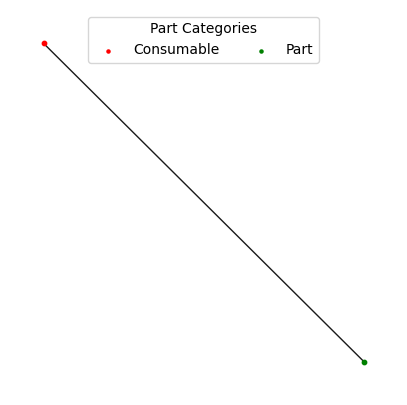

Component 95 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



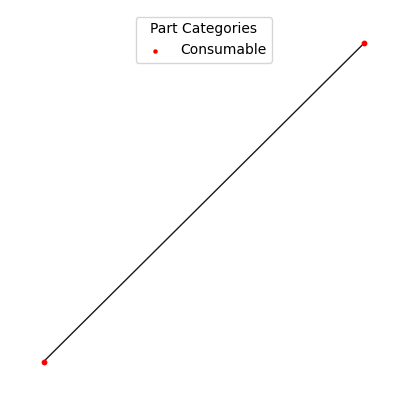

Component 96 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



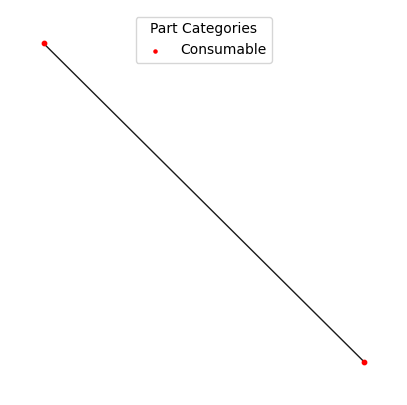

Component 97 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



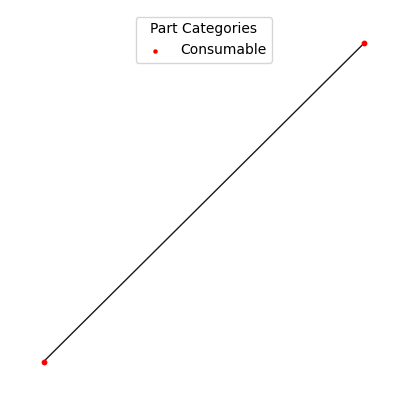

Component 98 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



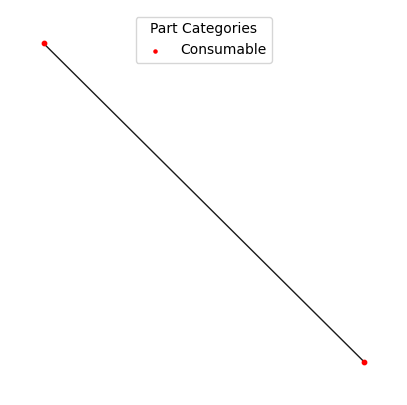

Component 99 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



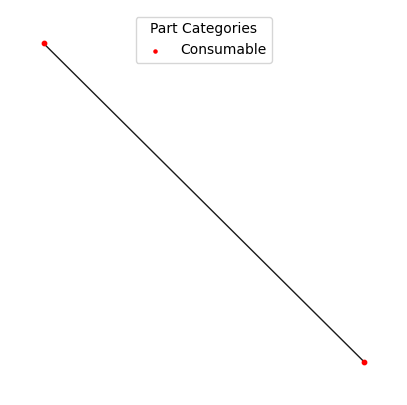

Component 100 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



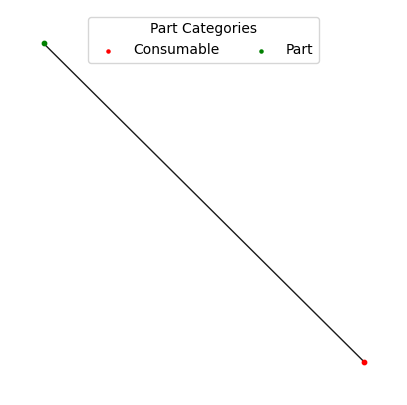

Component 101 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



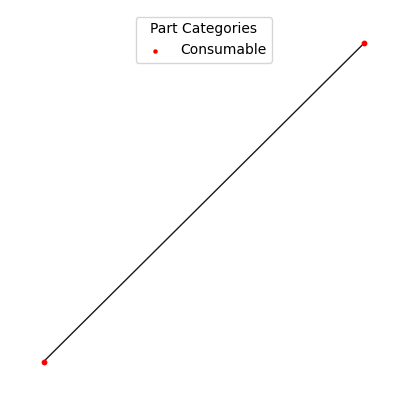

Component 102 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



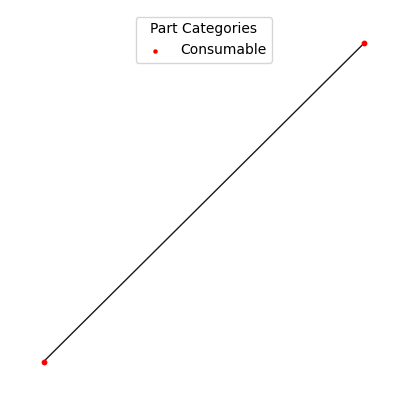

Component 103 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



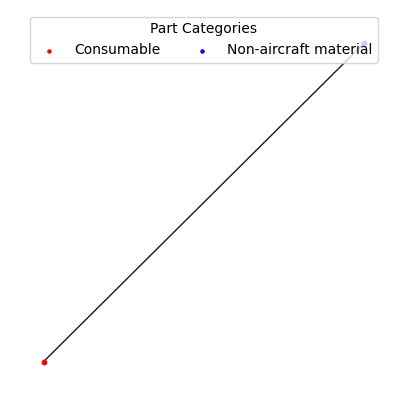

Component 104 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



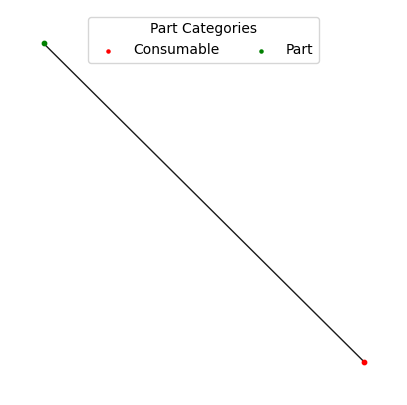

Component 105 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



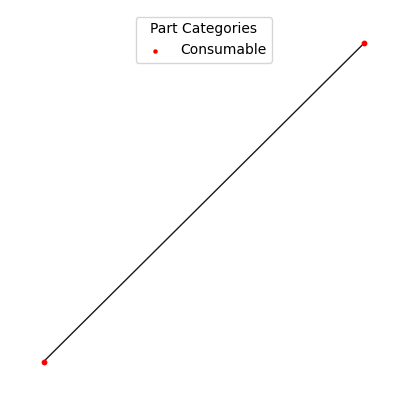

Component 106 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



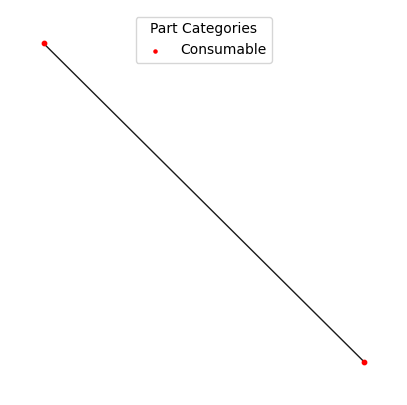

Component 107 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



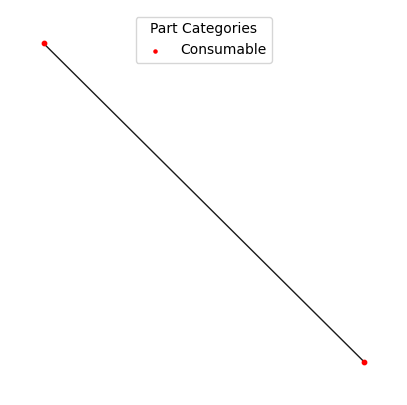

Component 108 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



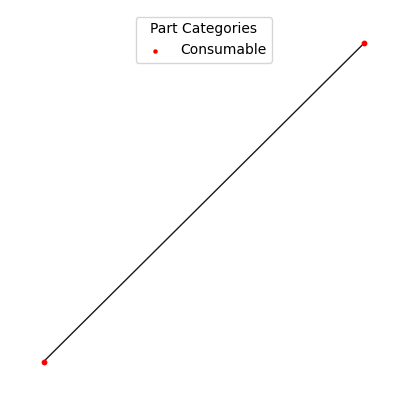

Component 109 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



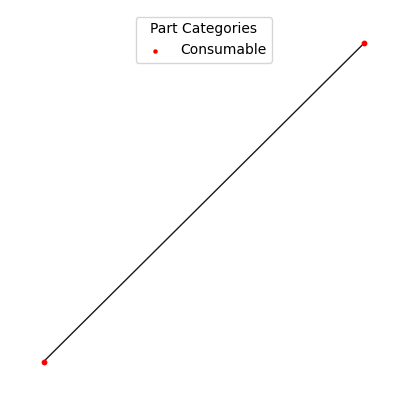

Component 110 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



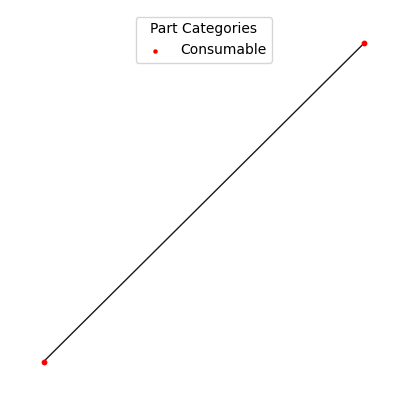

Component 111 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



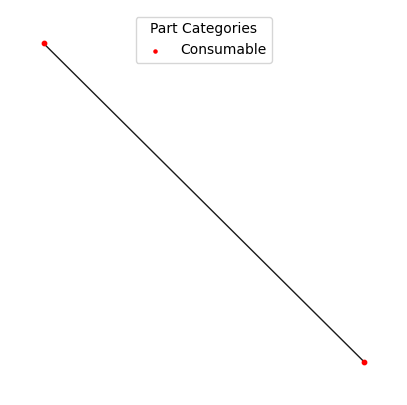

Component 112 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



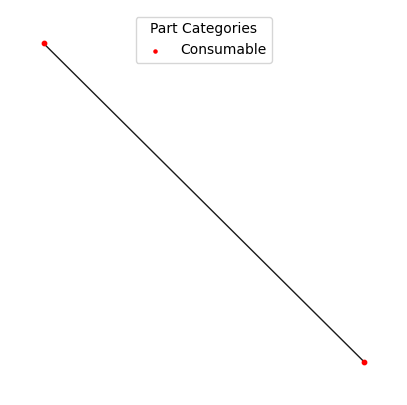

Component 113 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



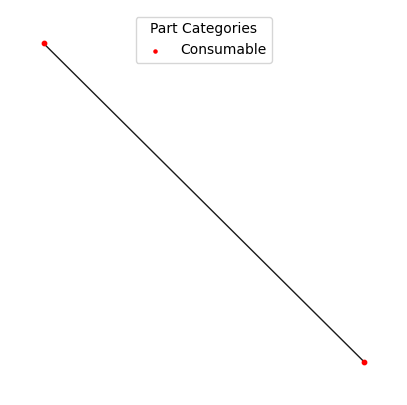

Component 114 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



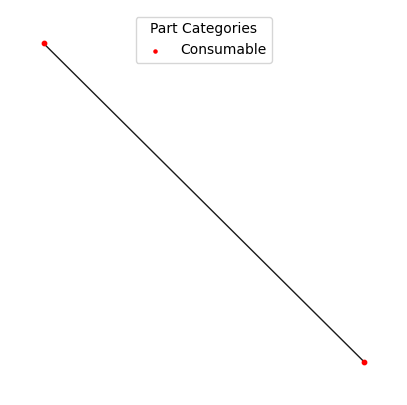

Component 115 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



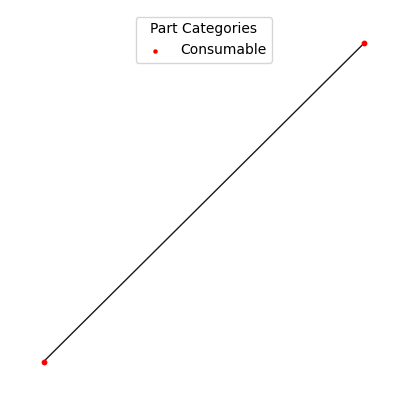

Component 116 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



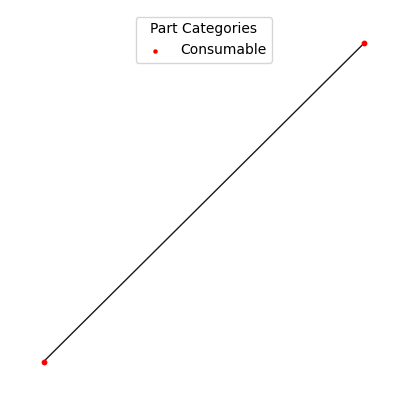

Component 117 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



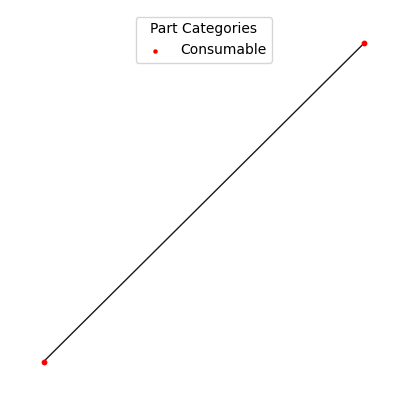

Component 118 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



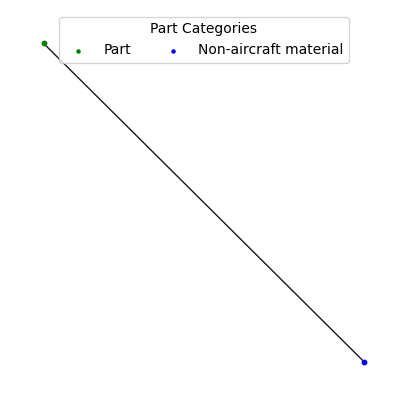

Component 119 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



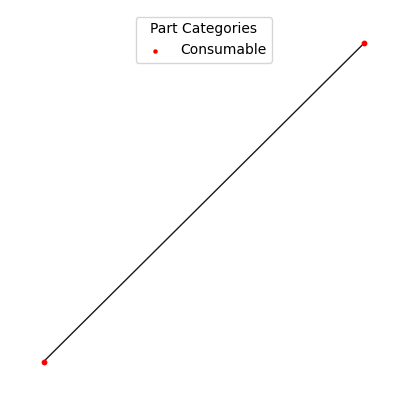

Component 120 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



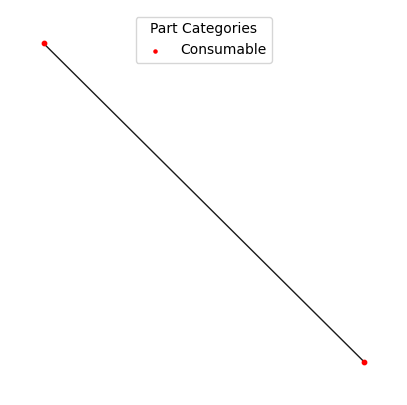

Component 121 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



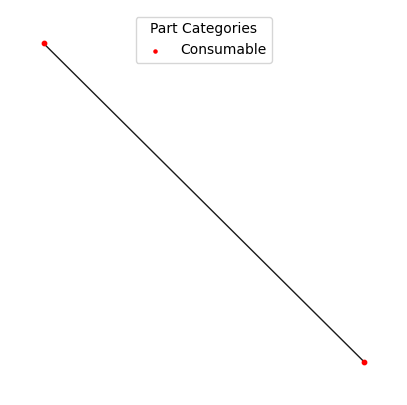

Component 122 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



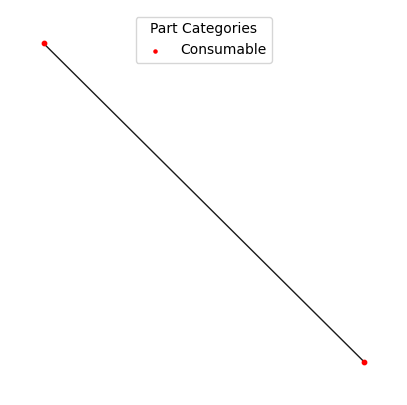

Component 123 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



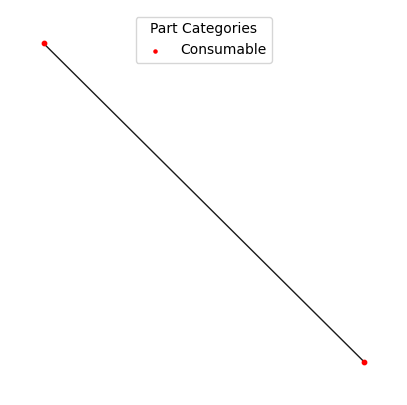

Component 124 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



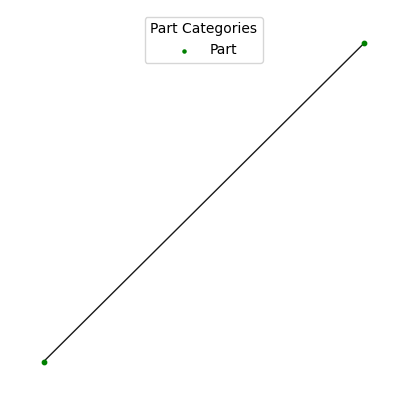

Component 125 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



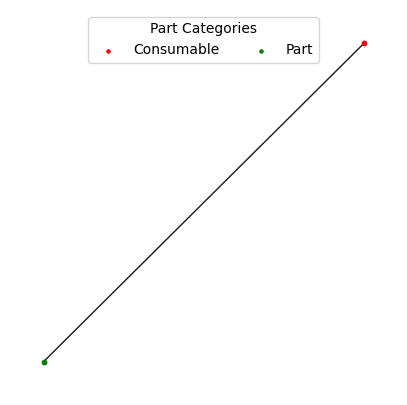

Component 126 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



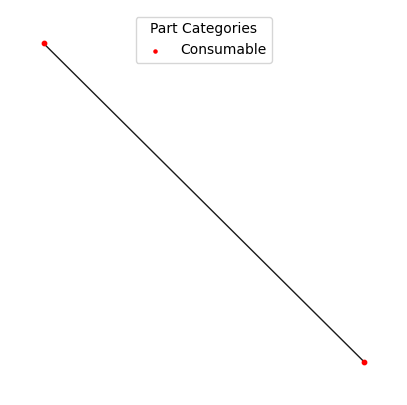

Component 127 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



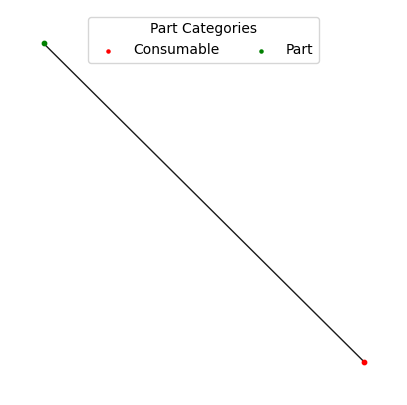

Component 128 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



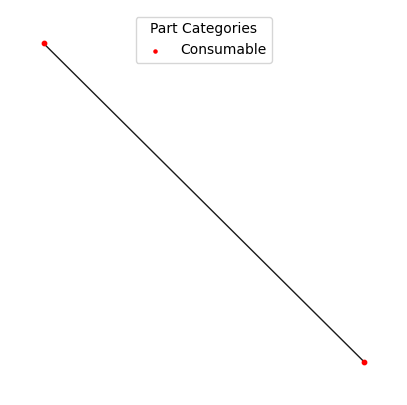

Component 129 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



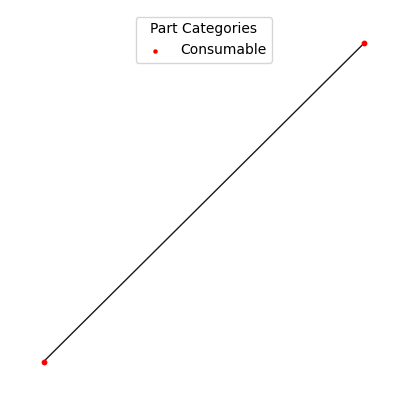

Component 130 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



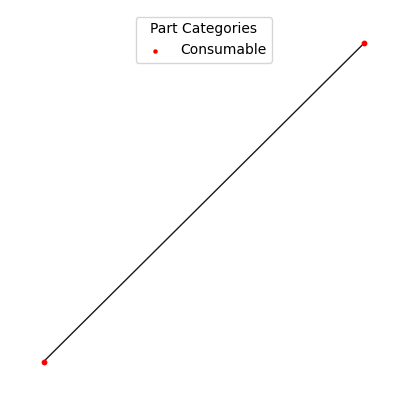

Component 131 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



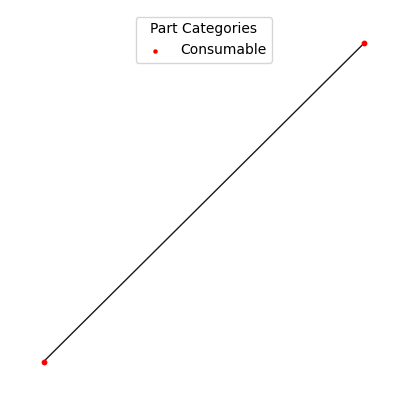

Component 132 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



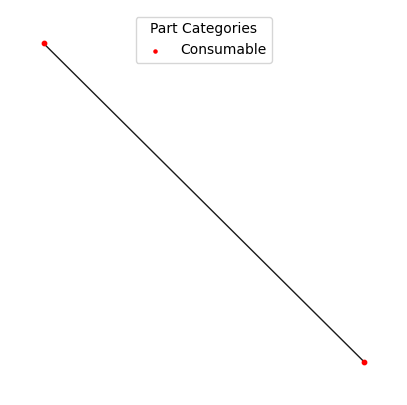

Component 133 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



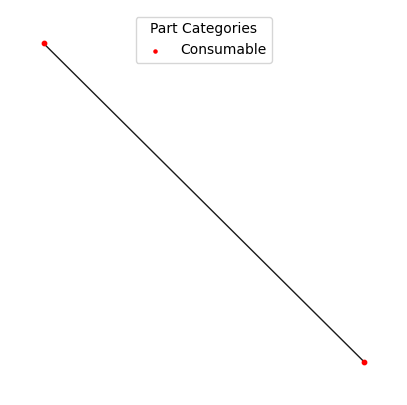

Component 134 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



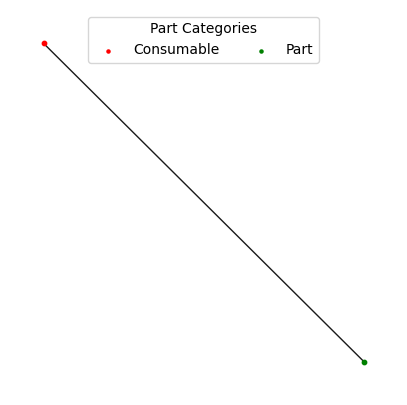

Component 135 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



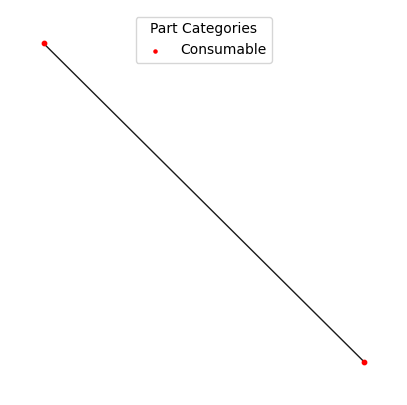

Component 136 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



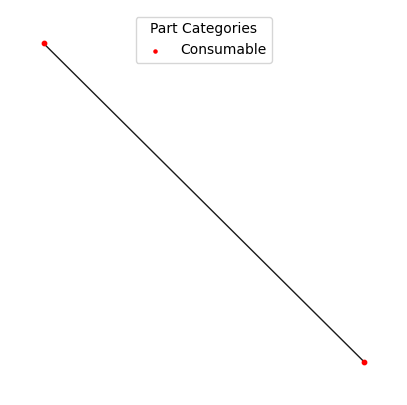

Component 137 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



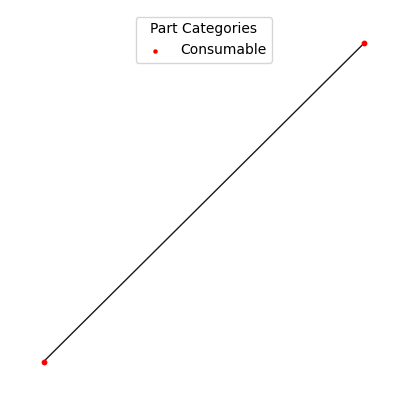

Component 138 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



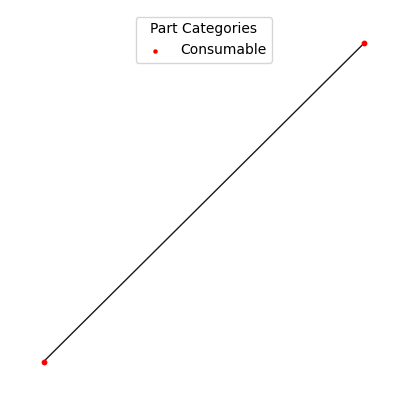

Component 139 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



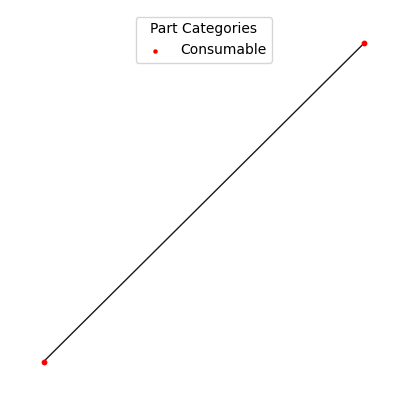

Component 140 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



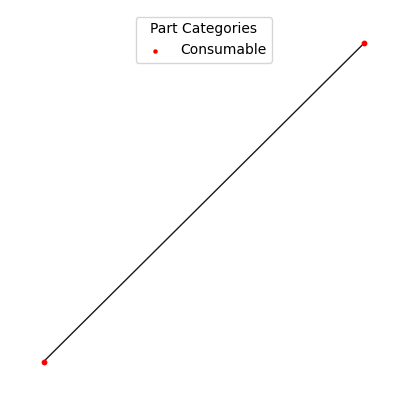

Component 141 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



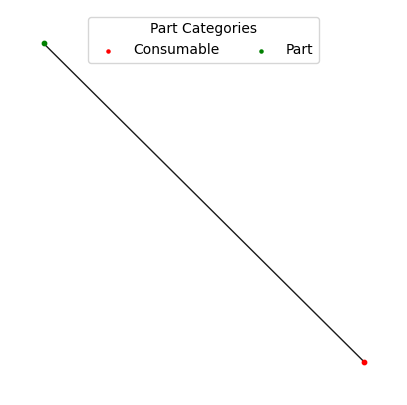

Component 142 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



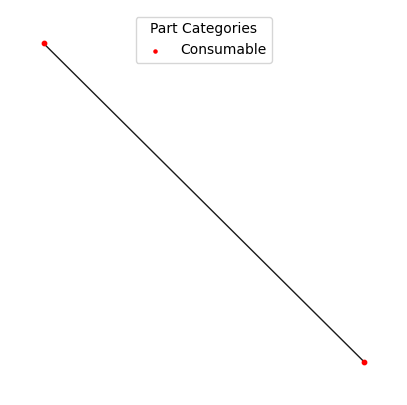

Component 143 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



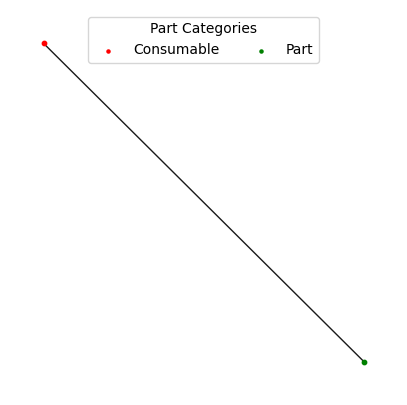

Component 144 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



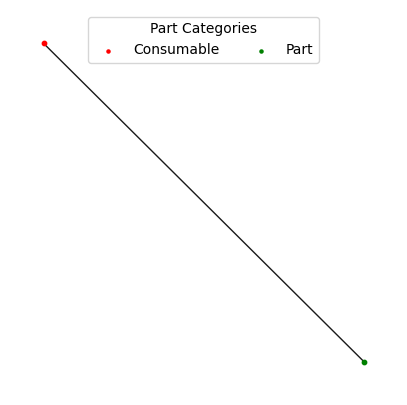

Component 145 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



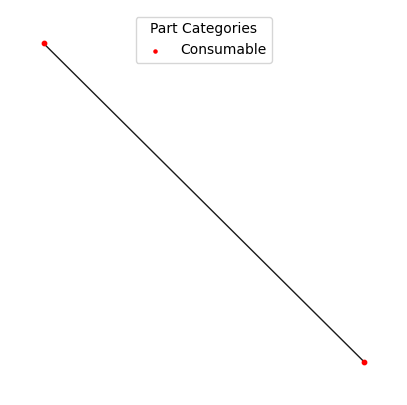

Component 146 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



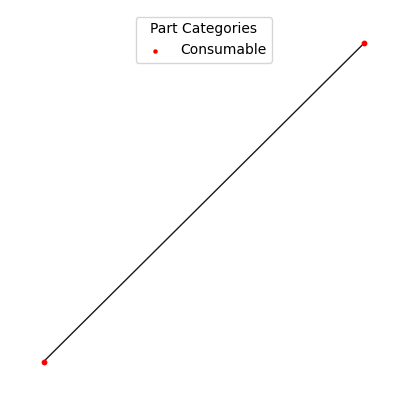

Component 147 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



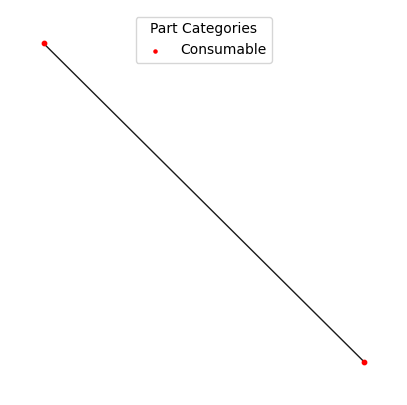

Component 148 : Graph with 2 nodes and 1 edges
Size: 2
Average clustering coefficient:  0.0
Density: 1.0



In [40]:

for i in range(len(S)):
  fig, ax = plt.subplots(figsize=(5,5))

  pos=nx.spring_layout(S[i])

  for category, color in color_map.items():
      category_nodes = [node for node in S[i].nodes() if S[i].nodes[node]["category"] == category]
      size_nodes=[S[i].nodes[node]["frequency"] for node in category_nodes]
      nx.draw_networkx_nodes(S[i], pos, nodelist=category_nodes, node_color=color, label=category,node_size=10)

  nx.draw_networkx_edges(S[i], pos, width=1.0, alpha=0.9)

  plt.axis("off")
  legend = ax.legend(title="Part Categories", loc='upper center', ncol=5)
  for handle in legend.legend_handles:
      handle.set_sizes([5])
  plt.show()

  print('Component',i,':', S[i])
  print('Size:',network_info[i]['size'])
  print('Average clustering coefficient: ',network_info[i]['cc'])
  print('Density:', network_info[i]['density'])
  print('')


# Community detection pt2 : Run community detection algorithm in the largest connected component

In [41]:
#insert colors for nodes

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

## Largest connected component info

In [42]:
i=0
print(S[i])
print('-------------------------------------------------------')
print('Average clustering coefficient: ',network_info[i]['cc'])
print('Density:', network_info[i]['density'])

Graph with 2618 nodes and 26317 edges
-------------------------------------------------------
Average clustering coefficient:  0.6608284687399877
Density: 0.007682330930774366


## Louvain algorithm on largest connected component  
- <b>Networkx documentation on Louvain algorithm</b>  
 https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html  

- <b>Modularity maximization approaches</b>   
https://arxiv.org/pdf/0803.0476.pdf  
https://web.eng.ucsd.edu/~massimo/ECE227/Handouts_files/TCSS-14-Modularity.pdf  
   

- <b>Network partition quality measures</b>
  * <b>Modularity</b> quantifies the community strength by comparing
the fraction of edges within the community with the one when random connections between the nodes are made. A community is expected to
have more links between its entities than the ones resulted by the same entities connected at random with the same number of links.
  * <b>Coverage</b> of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
  * <b>Performance</b> of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.




In [43]:
def comd_louvain(G):
  start = time.time()
  c=list(nx.algorithms.community.louvain_communities(G,'weight',resolution=1))
  end = time.time()
  print('Execution time:', end - start)
  mm_G=[]
  for i,j in enumerate(c):
      a=list(j)
      mm_G.append(a)
  per=nx.algorithms.community.quality.modularity(G,mm_G)
  per1=nx.algorithms.community.quality.partition_quality(G,mm_G)
  num_G=len(mm_G)
  return mm_G, per,num_G, per1[1], per1[0]

In [44]:
mm_G, modul, num_G, per, cov = comd_louvain(S[0])

Execution time: 0.9600894451141357


In [45]:
def generate_hist(metric_res, metric_name):
  plt.hist(metric_res, bins=100, edgecolor='black')
  plt.ylabel("Count")
  plt.xlabel(metric_name)
  plt.show()

  print("Component Average {}:".format(metric_name), np.mean(metric_res))
  print("Component {} Standard Deviation:".format(metric_name), np.std(metric_res))
  print("Minimun Component {}:".format(metric_name), min(metric_res))
  print("Maximum Component {}:".format(metric_name), max(metric_res))
  print('')

In [46]:
def evaluate_partition(coms,G):
  cc_com=[]
  density_com=[]
  in_strength_com=[]
  in_edges_num=[]

  out_strength_com=[]
  out_edges_num=[]

  for com in range(len(coms)):
    coms_g=G.subgraph(coms[com])
    in_edges_num.append(len(coms_g.edges()))
    cc_com.append(nx.average_clustering(coms_g))
    if len(coms_g.edges)>0:
      density_com.append(2*len(dict(coms_g.edges()))/(len(dict(coms_g.nodes()))*(len(dict(coms_g.nodes()))-1)))
    else:
      density_com.append(1)

    istr=0
    for e in coms_g.edges:
      istr+=G[e[0]][e[1]]['weight']
    in_strength_com.append(istr)

    out_neig=0
    ostr=0
    for n in coms[com]:
      for n2 in G.neighbors(n):
        if n2 not in coms_g.neighbors(n):
          out_neig+=1
          ostr+=G[n][n2]['weight']
    out_strength_com.append(ostr)
    out_edges_num.append(out_neig)

    in_strength_ratio=[in_strength_com[i]/(in_strength_com[i]+out_strength_com[i]) for i in range(len(in_strength_com))]
    in_edge_ratio=[in_edges_num[i]/(in_edges_num[i]+out_edges_num[i]) for i in range(len(in_edges_num))]

  return(cc_com,density_com,in_strength_ratio,in_edge_ratio)

In [47]:
cc_com,density_com,in_strength_ratio,in_edge_ratio=evaluate_partition(mm_G,G)

In [48]:
print('LOUVAIN results')
print('--------------------------------------------------------------------')
print('Number of communities:', num_G)
print('')
print('Modularity score:', modul)
print('Performance score:', per)
print('Coverage score:', cov)
print('')
print('Average community size:', np.mean([len(i) for i in mm_G]))
print('Standard deviation of community size:', np.std([len(i) for i in mm_G]))
print('Max community size:', max([len(i) for i in mm_G]))
print('Min community size:', min([len(i) for i in mm_G]))
print('--------------------------------------------------------------------')
counter = collections.Counter(sorted([len(i) for i in mm_G]))
for c in counter:
  print('-', counter[c], 'community/ies of size ', c)

LOUVAIN results
--------------------------------------------------------------------
Number of communities: 41

Modularity score: 0.744155680725659
Performance score: 0.9196865531914645
Coverage score: 0.8398373674810958

Average community size: 63.853658536585364
Standard deviation of community size: 101.3897481168608
Max community size: 492
Min community size: 2
--------------------------------------------------------------------
- 4 community/ies of size  2
- 2 community/ies of size  4
- 2 community/ies of size  5
- 1 community/ies of size  6
- 1 community/ies of size  7
- 3 community/ies of size  8
- 3 community/ies of size  9
- 1 community/ies of size  13
- 1 community/ies of size  15
- 1 community/ies of size  19
- 1 community/ies of size  22
- 1 community/ies of size  24
- 1 community/ies of size  32
- 2 community/ies of size  34
- 1 community/ies of size  39
- 1 community/ies of size  48
- 1 community/ies of size  53
- 1 community/ies of size  55
- 2 community/ies of size  62
-

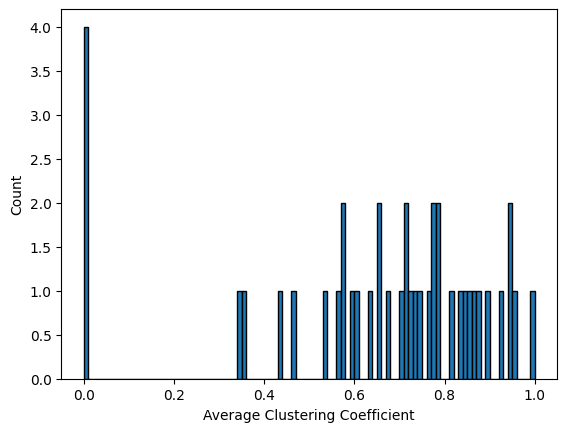

Component Average Average Clustering Coefficient: 0.6498588974601478
Component Average Clustering Coefficient Standard Deviation: 0.26426345050546407
Minimun Component Average Clustering Coefficient: 0.0
Maximum Component Average Clustering Coefficient: 1.0




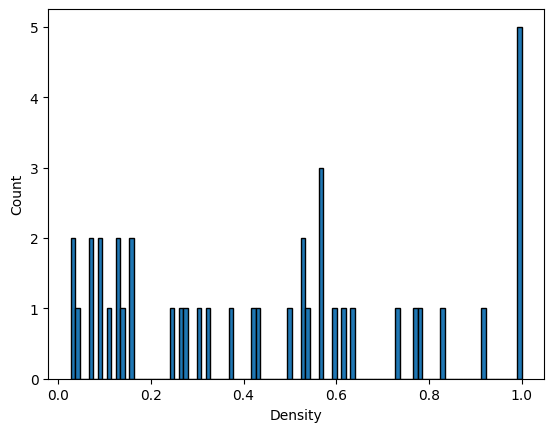

Component Average Density: 0.45244023701450103
Component Density Standard Deviation: 0.3178365792944006
Minimun Component Density: 0.027074629311051035
Maximum Component Density: 1.0




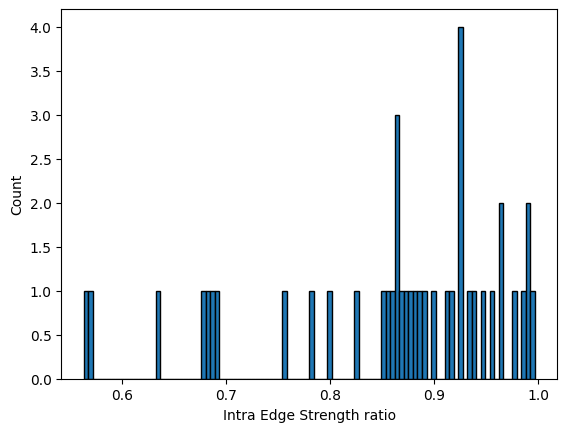

Component Average Intra Edge Strength ratio: 0.8581778262788465
Component Intra Edge Strength ratio Standard Deviation: 0.11332935460823225
Minimun Component Intra Edge Strength ratio: 0.5631564772421223
Maximum Component Intra Edge Strength ratio: 0.9965463650492143




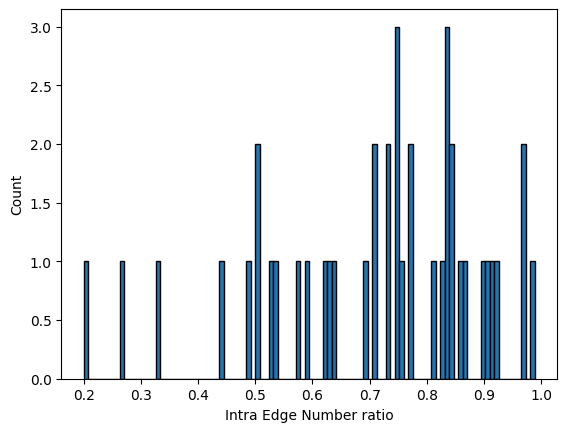

Component Average Intra Edge Number ratio: 0.7097807863801446
Component Intra Edge Number ratio Standard Deviation: 0.1889642656069786
Minimun Component Intra Edge Number ratio: 0.2
Maximum Component Intra Edge Number ratio: 0.9889282550930026



In [49]:
generate_hist(cc_com, 'Average Clustering Coefficient')
print('')
generate_hist(density_com, 'Density')
print('')
generate_hist(in_strength_ratio, 'Intra Edge Strength ratio')
print('')
generate_hist(in_edge_ratio, 'Intra Edge Number ratio')

# Graph of communities
Measure similarity between communities

In [50]:
def communities_sim(com,G): # com: node partition, G: initial graph

  com_sim=dict()
  com_edges=dict()
  for com1 in range(len(com)):
    for com2 in range(com1,len(com)):
      csim=0
      cedges=0
      for n1 in com[com1]:
        for n2 in com[com2]:
          if n1 in G.neighbors(n2):
            cedges+=1
            csim+=G[n1][n2]['weight']
      com_edges[(com1,com2)]=cedges
      com_sim[(com1,com2)]=csim

  return com_edges,com_sim


In [51]:
com_edges,com_sim=communities_sim(mm_G,G)

Similarity btw communities = total strength of inter-community edges

In [52]:
com_sim
com_sim_source=[i[0] for i in com_sim]
com_sim_dest=[i[1] for i in com_sim]
com_sim_sim=[com_sim[i] for i in com_sim]
data={'source':com_sim_source, 'destination':com_sim_dest, 'similarity':com_sim_sim}
df_sim=pd.DataFrame.from_dict(data)

## Communities similarity dataframe

In [53]:
df_sim

source  destination  similarity
0         0            0        5758
1         0            1           0
2         0            2           0
3         0            3           0
4         0            4          76
..      ...          ...         ...
856      38           39           0
857      38           40           0
858      39           39          66
859      39           40           0
860      40           40         242

[861 rows x 3 columns]

In [54]:
df_sim[(df_sim['similarity']!=0) & ((df_sim['source']==1) | (df_sim['destination']==1))].sort_values(by=['similarity'],ascending=False)

source  destination  similarity
41       1            1       13628
57       1           17         567
45       1            5         265
64       1           24         253
50       1           10         213
48       1            8         208
44       1            4         174
62       1           22         137
72       1           32          30
47       1            7          28
73       1           33          10
70       1           30           8
71       1           31           8

In [55]:
G_com=nx.Graph()
for i in com_sim:
  if com_sim[i]>0 and i[0]!=i[1]:
    G_com.add_edge(i[0],i[1],similarity=com_sim[i])
  elif i[0]==i[1]:
    G_com.add_node(i[0], strength=com_sim[i])

(-1.1807134477764496,
 0.9017939027902548,
 -1.1612832559719688,
 0.979024734884872)

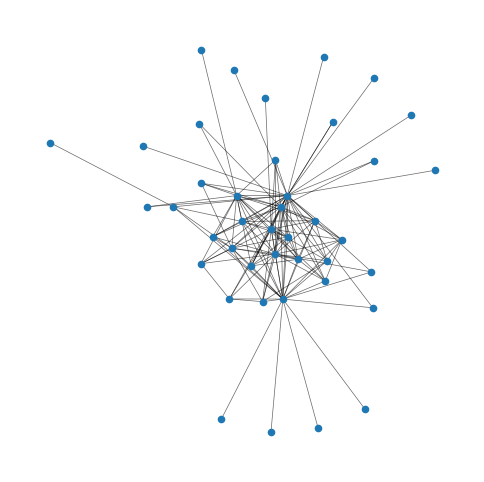

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
pos=nx.spring_layout(G_com)

nx.draw_networkx_nodes(G_com, pos, nodelist=G_com.nodes(),node_size=20, alpha=1)
nx.draw_networkx_edges(G_com, pos, width=0.5, alpha=0.6)

plt.axis("off")

In [57]:
end=time.time()
print((end-start)/60, 'mins')

2.9912340601285297 mins
